## **Data Loading**

In [54]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import boxcox
import statsmodels.stats as sm_stats
from torch.utils.data import DataLoader
import warnings
import wandb

data, meta = arff.loadarff('MagicTelescope.arff')

df = pd.DataFrame(data)

# --- Normalize column names: strip whitespace, remove special chars, make lowercase ---
df.columns = df.columns.astype(str).str.strip() \
                       .str.replace(r'[^0-9A-Za-z_]', '', regex=True)

df['class'] = df['class'].str.decode('utf-8')

# strip whitespace from string columns
str_cols = df.select_dtypes(include=['object']).columns
for col in str_cols:
    df[col] = df[col].str.strip()

## **Descriptive Statistics**

In [55]:
df.head()

ID   fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  \
0  1.0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   
1  2.0   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   
2  3.0  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580   
3  4.0   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   
4  5.0   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   

   fM3Trans   fAlpha     fDist class  
0   -8.2027  40.0920   81.8828     g  
1   -9.9574   6.3609  205.2610     g  
2  -45.2160  76.9600  256.7880     g  
3   -7.1513  10.4490  116.7370     g  
4   21.8393   4.6480  356.4620     g

In [56]:
df.shape

(19020, 12)

In [57]:
df.describe()

ID       fLength        fWidth         fSize         fConc  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean    9510.500000     53.250154     22.180966      2.825017      0.380327   
std     5490.745396     42.364855     18.346056      0.472599      0.182813   
min        1.000000      4.283500      0.000000      1.941300      0.013100   
25%     4755.750000     24.336000     11.863800      2.477100      0.235800   
50%     9510.500000     37.147700     17.139900      2.739600      0.354150   
75%    14265.250000     70.122175     24.739475      3.101600      0.503700   
max    19020.000000    334.177000    256.382000      5.323300      0.893000   

             fConc1         fAsym       fM3Long      fM3Trans        fAlpha  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean       0.214657     -4.331745     10.545545      0.249726     27.645707   
std        0.110511     59.206062     51.000118     20.827439     26.103621   
min        0.000300   -457.916100   -331.780000   -205.894700      0.000000   
25%        0.128475    -20.586550    -12.842775    -10.849375      5.547925   
50%        0.196500      4.013050     15.314100      0.666200     17.679500   
75%        0.285225     24.063700     35.837800     10.946425     45.883550   
max        0.675200    575.240700    238.321000    179.851000     90.000000   

              fDist  
count  19020.000000  
mean     193.818026  
std       74.731787  
min        1.282600  
25%      142.492250  
50%      191.851450  
75%      240.563825  
max      495.561000

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        19020 non-null  float64
 1   fLength   19020 non-null  float64
 2   fWidth    19020 non-null  float64
 3   fSize     19020 non-null  float64
 4   fConc     19020 non-null  float64
 5   fConc1    19020 non-null  float64
 6   fAsym     19020 non-null  float64
 7   fM3Long   19020 non-null  float64
 8   fM3Trans  19020 non-null  float64
 9   fAlpha    19020 non-null  float64
 10  fDist     19020 non-null  float64
 11  class     19020 non-null  object 
dtypes: float64(11), object(1)
memory usage: 1.7+ MB


In [59]:
df.nunique()

ID          19020
fLength     18643
fWidth      18200
fSize        7228
fConc        6410
fConc1       4421
fAsym       18704
fM3Long     18693
fM3Trans    18390
fAlpha      17981
fDist       18437
class           2
dtype: int64

In [60]:
print(df.duplicated().sum())

0


In [61]:
print(df.isna().sum())

ID          0
fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64


In [62]:
# we will do binary classification and thus we need to convert the target variable to 0 and 1
class_mapping = {'g': 1, 'h': 0}
df['class'] = df['class'].map(class_mapping)

# Drop ID column as it is not useful for modeling
df.drop('ID', axis=1, inplace=True)

df.head()



fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1

In [63]:
data_all = df[col].dropna()
data_g = df[df['class'] == class_mapping['g']][col].dropna()  # 1 for 'g'
data_h = df[df['class'] == class_mapping['h']][col].dropna()  # 0 for 'h'

In [64]:
numeric_df = df.select_dtypes(include=[np.number])
cols = numeric_df.columns

correlations = []

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col1, col2 = cols[i], cols[j]
        corr_value = np.corrcoef(df[col1], df[col2])[0, 1]
        correlations.append((col1, col2, corr_value))

corr_df = pd.DataFrame(correlations, columns=["Feature 1", "Feature 2", "Correlation"])

corr_df = corr_df.sort_values(by="Correlation", ascending=False)

print("Top 20 najsilnejších korelácií:")
print(corr_df.head(10))
print(corr_df.tail(10))

Top 20 najsilnejších korelácií:
   Feature 1 Feature 2  Correlation
27     fConc    fConc1     0.976412
0    fLength    fWidth     0.770512
10    fWidth     fSize     0.717517
1    fLength     fSize     0.702454
25     fSize     fDist     0.437041
8    fLength     fDist     0.418466
17    fWidth     fDist     0.336816
40     fAsym   fM3Long     0.274045
31     fConc    fAlpha     0.235272
37    fConc1    fAlpha     0.229799
   Feature 1 Feature 2  Correlation
9    fLength     class    -0.307572
32     fConc     fDist    -0.328332
4    fLength     fAsym    -0.368556
53    fAlpha     class    -0.460979
12    fWidth    fConc1    -0.581141
3    fLength    fConc1    -0.598145
11    fWidth     fConc    -0.609779
2    fLength     fConc    -0.630999
20     fSize    fConc1    -0.808835
19     fSize     fConc    -0.850850


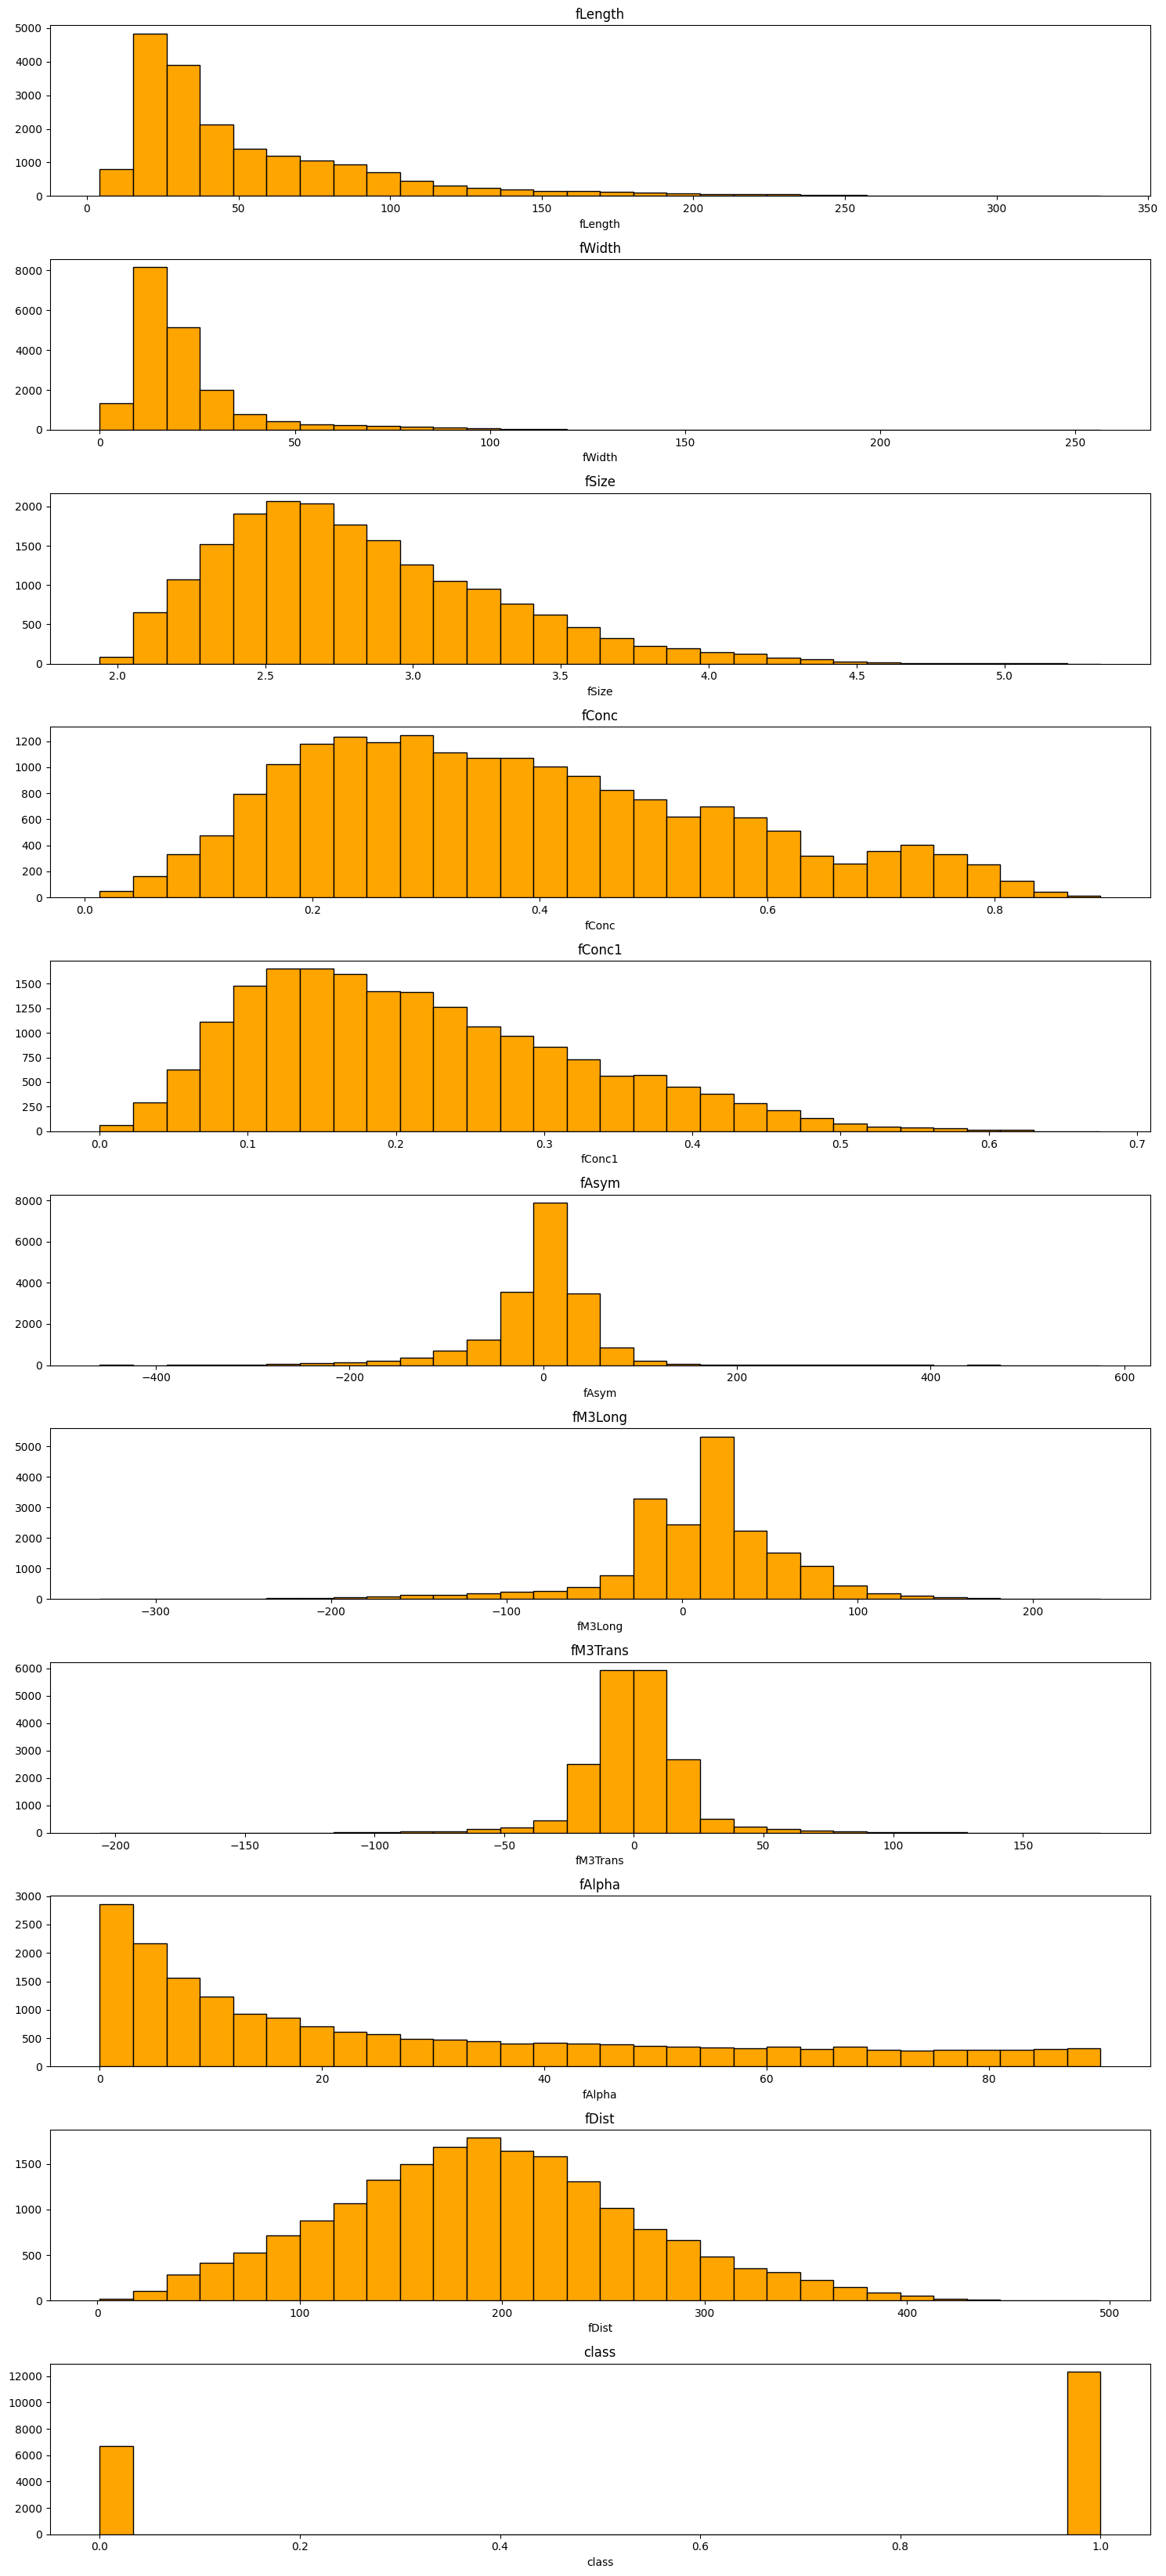

In [13]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.hist(df[col].dropna(), bins=30, color = "orange", edgecolor='black')
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

## **Outlier Detection and Handling**

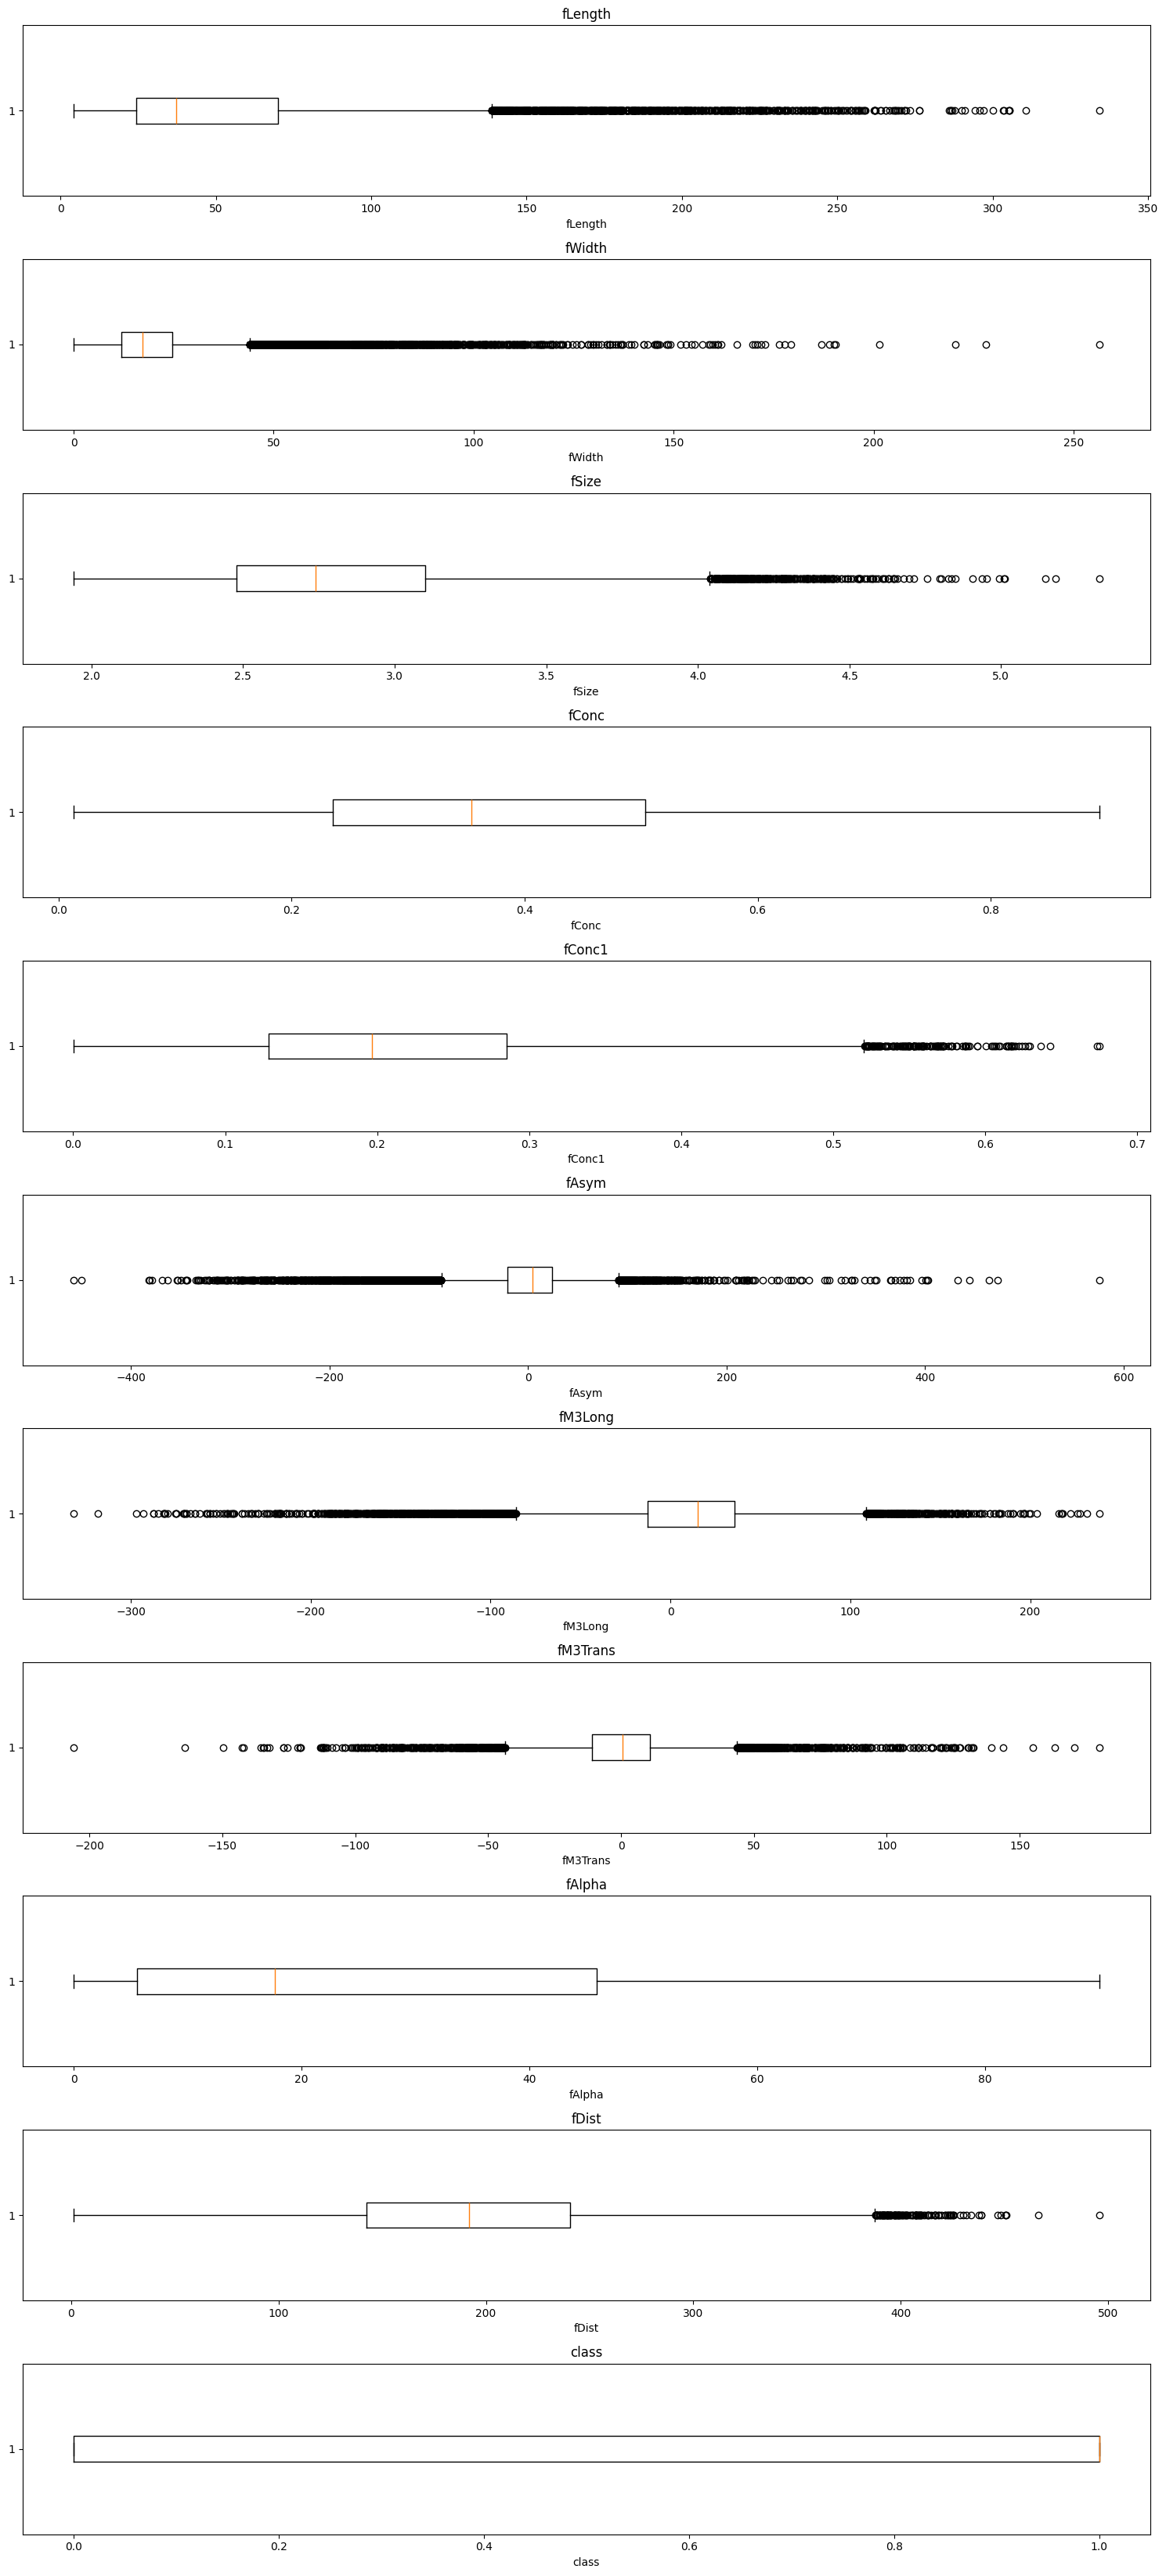

In [14]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [15]:
numeric_df = df.select_dtypes(include=[np.number])

for col in numeric_df.columns:
    stat, p = shapiro(df[col])
    print(p)

8.133404060550683e-93
1.5423236511023563e-103
1.0950393740021794e-60
1.0260738464095494e-52
3.0703986576980104e-56
4.133179728229826e-84
1.4561558074025387e-72
1.0034033956235664e-78
6.257989223858619e-82
3.562749318318082e-25
1.0304298450095123e-108


C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19020.
  res = hypotest_fun_out(*samples, **kwds)


In [16]:
outliers_count = {}

for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    count = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)][col].count()
    outliers_count[col] = count

outliers_df = pd.DataFrame(list(outliers_count.items()), columns=['Column', 'Outliers_Count'])
outliers_df = outliers_df.sort_values(by='Outliers_Count', ascending=False)

print(outliers_df)

      Column  Outliers_Count
5      fAsym            1781
1     fWidth            1546
6    fM3Long            1218
0    fLength             971
7   fM3Trans             850
2      fSize             367
4     fConc1             150
9      fDist             128
3      fConc               0
8     fAlpha               0
10     class               0


In [17]:
# Apply Box-Cox transformation to columns with high outlier counts to reduce skewness and outliers
# Box-Cox requires positive values; shift if necessary

columns_to_transform = ['fAsym', 'fWidth', 'fM3Long', 'fLength', 'fM3Trans', 'fConc1', 'fDist', 'fSize']

for col in columns_to_transform:
    if col in df.columns and df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        if (df[col] <= 0).any():
            shift = 1 - df[col].min()  # Shift to make all positive
            df[col] = df[col] + shift
        df[col], _ = boxcox(df[col])
        print(f"Box-Cox applied to {col}")

# Note: 'ID', 'fConc', 'fAlpha', 'class' have no outliers or are not numeric/transformable

Box-Cox applied to fAsym
Box-Cox applied to fWidth
Box-Cox applied to fM3Long
Box-Cox applied to fLength
Box-Cox applied to fM3Trans
Box-Cox applied to fConc1
Box-Cox applied to fDist
Box-Cox applied to fSize


In [18]:
# Alternative: Drop outliers instead of transforming
# Identify and drop rows where any of the outlier-prone columns have outliers (using IQR method)

# columns_with_outliers = ['fAsym', 'fWidth', 'fM3Long', 'fLength', 'fM3Trans', 'fConc1', 'fDist', 'fSize']

# # Create a mask to keep rows without outliers in any of these columns
# mask = pd.Series([True] * len(df), index=df.index)

# for col in columns_with_outliers:
#     if col in df.columns and df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)

# # Drop rows with outliers
# df = df[mask]

# print(f"Rows after dropping outliers: {len(df)}")
# print(f"Rows dropped: {len(mask) - len(df)}")

# Note: This removes rows where any of the specified columns have outliers. Adjust the list or logic if needed.
# After dropping, you can proceed with visualization or modeling.

In [19]:
# print(df['class'].value_counts())  # Omitted as per request

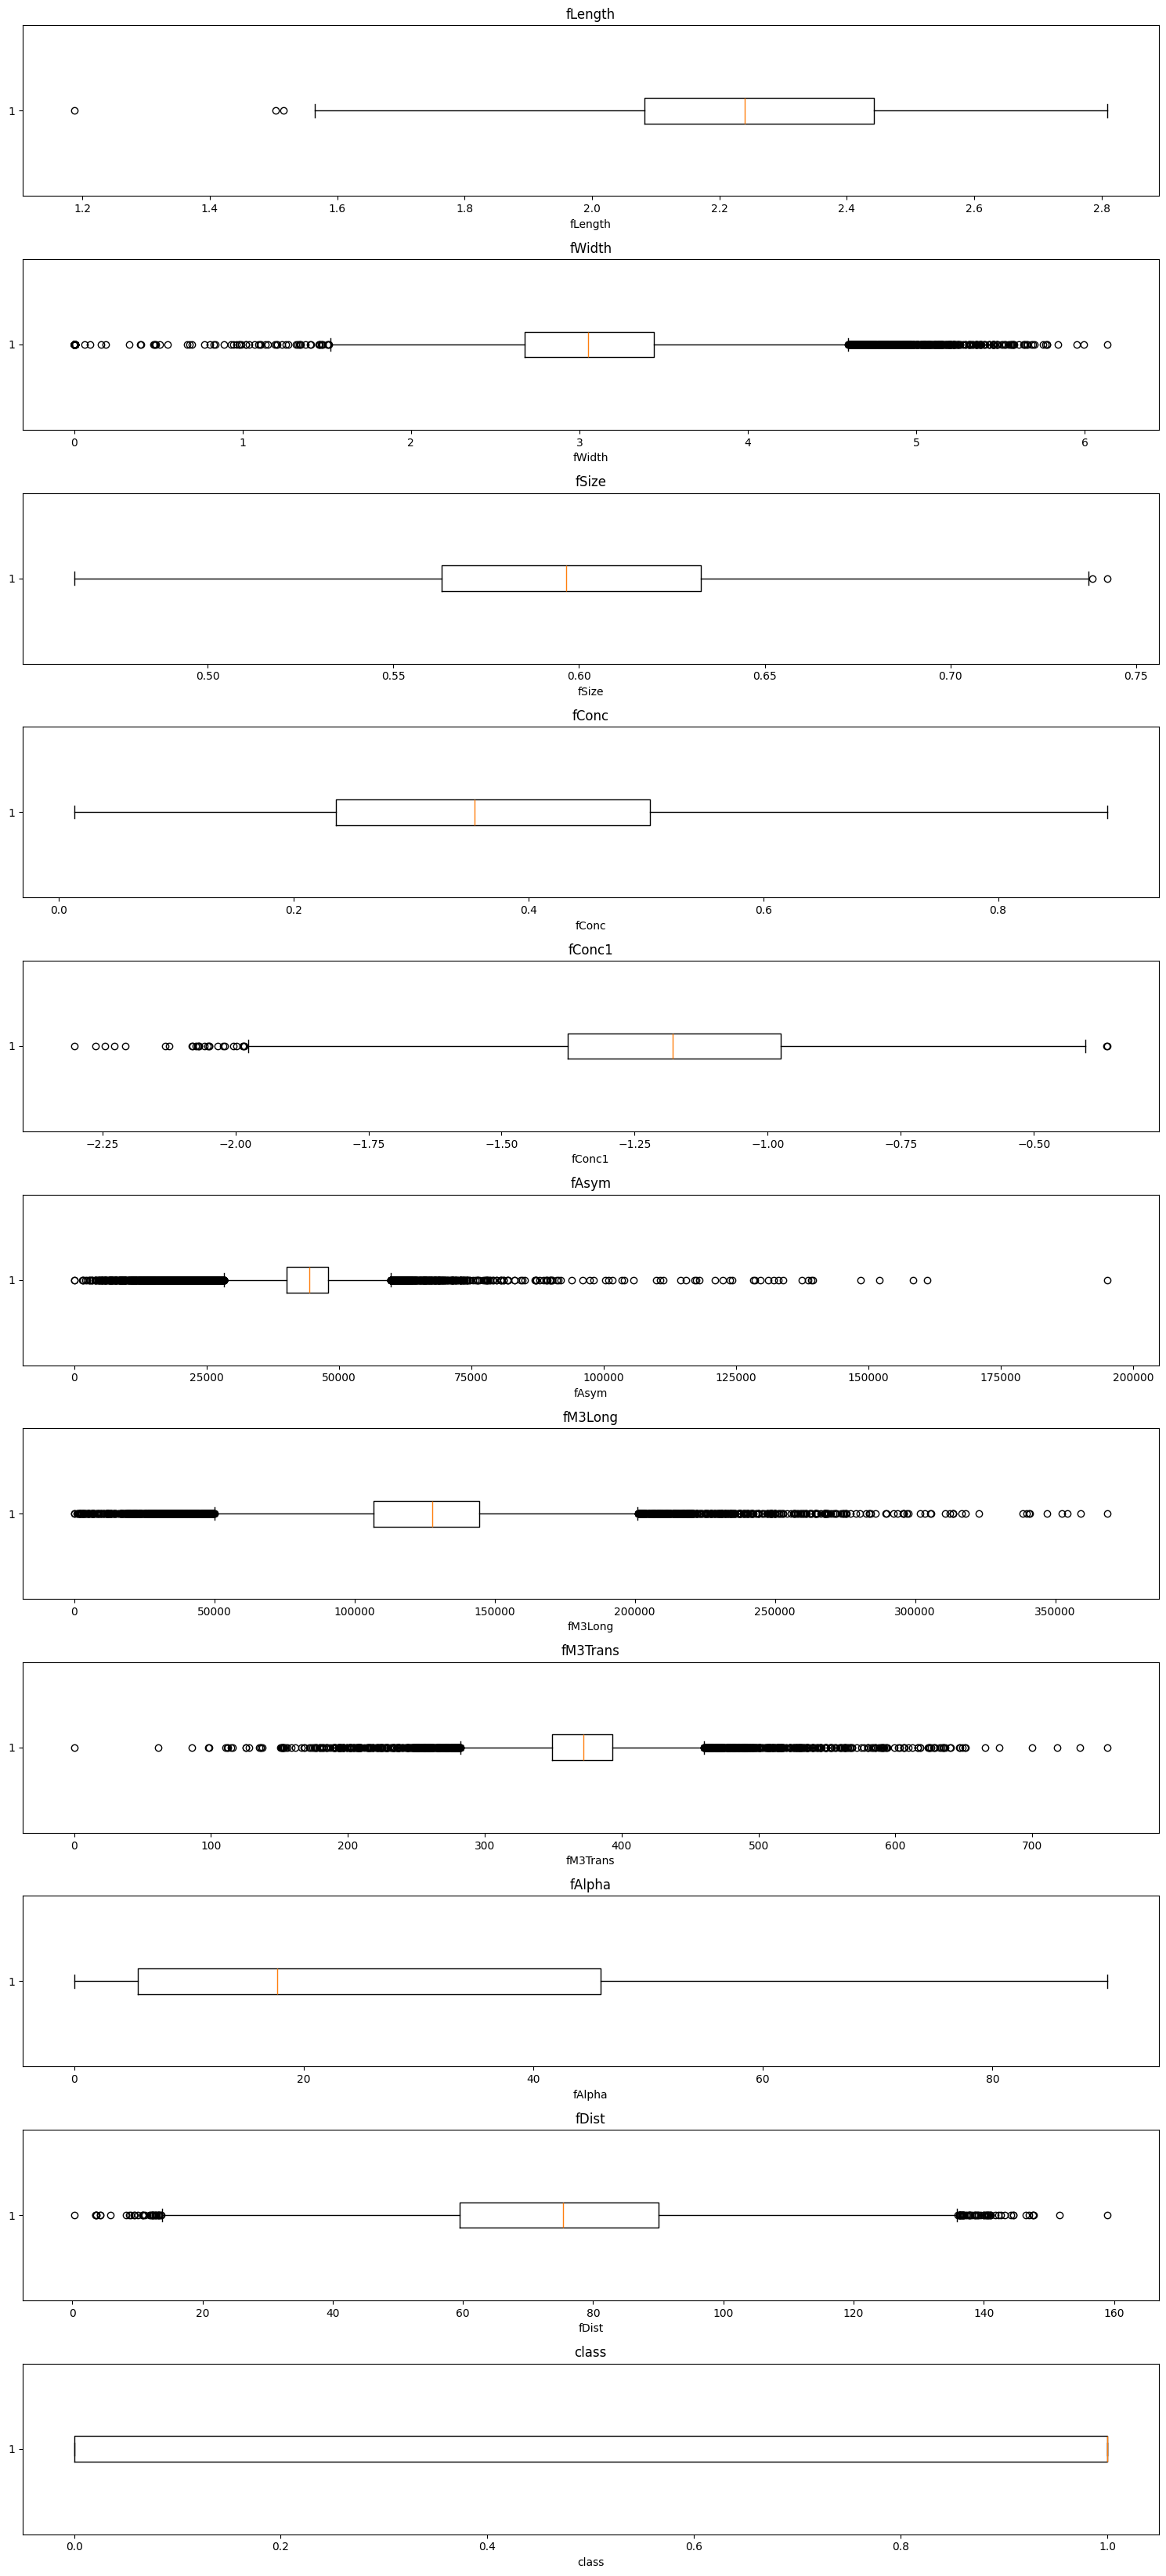

In [20]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

For me it's a big problem to figure out what to do with outlires because it's our data and we can't just throw it away if we aren't sure that it has som problems. I have used boxcox to minimize influence and reduce amount of oulires in fSz.

## **Pairwise Correlation Matrix**

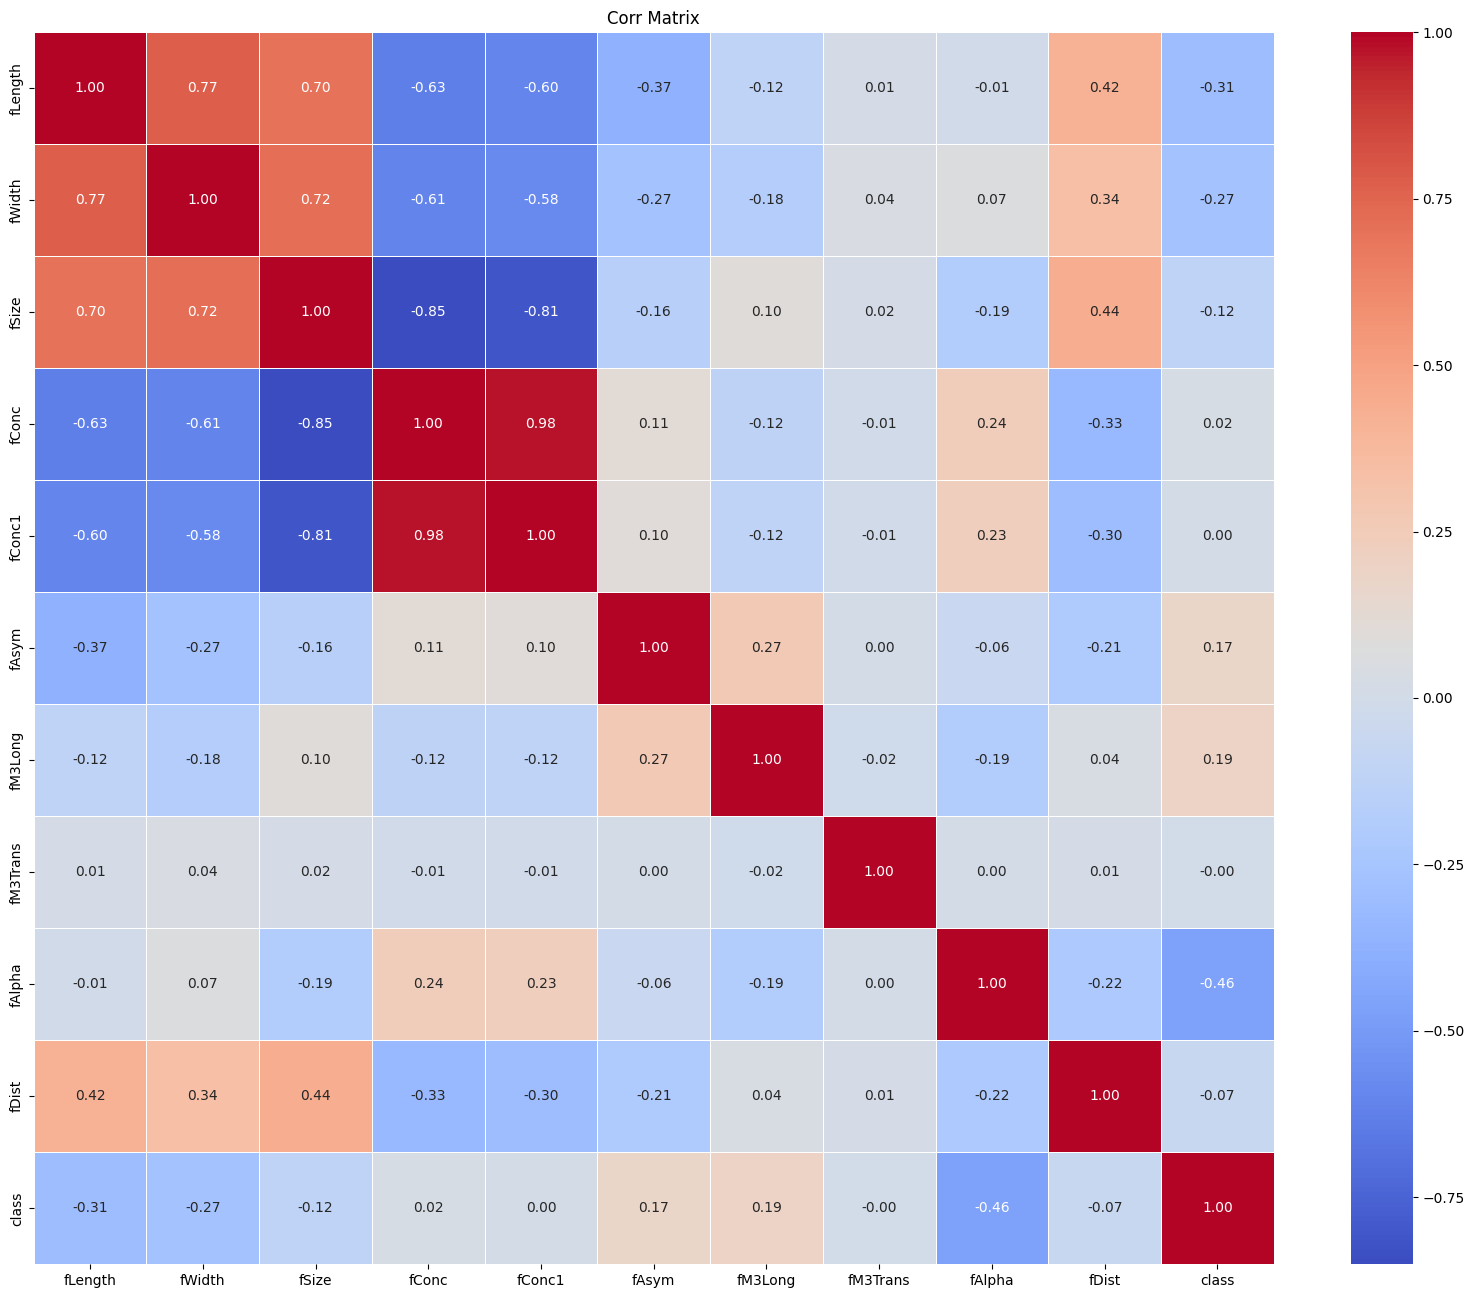

In [21]:
relationships_matrix = numeric_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(relationships_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Corr Matrix')
plt.show()

In [22]:
numeric_df = df.select_dtypes(include=[np.number])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.6 MB


In [23]:
# Calculate correlations with 'class'
correlations_abs = numeric_df.corr()['class'].abs().sort_values(ascending=False)
correlations_signed = numeric_df.corr()['class'][correlations_abs.index]

result_df = pd.DataFrame({
    'Feature': correlations_abs.index,
    'Abs Correlation': correlations_abs.values,
    'Signed Correlation': correlations_signed.values
})

print("Strongest correlations with 'class' (ordered by absolute value):")
print(result_df.to_string(index=False))

Strongest correlations with 'class' (ordered by absolute value):
 Feature  Abs Correlation  Signed Correlation
   class         1.000000            1.000000
  fAlpha         0.460979           -0.460979
 fLength         0.204748           -0.204748
  fWidth         0.161381           -0.161381
 fM3Long         0.143027            0.143027
   fAsym         0.139580            0.139580
   fSize         0.127929           -0.127929
   fDist         0.058541           -0.058541
  fConc1         0.028271            0.028271
   fConc         0.024615            0.024615
fM3Trans         0.009237           -0.009237


In [24]:
sns.pairplot(
    df,
    corner=False,
    plot_kws={'alpha': 1.0, 's': 20},
    hue='class',  # Pridanie farebného rozlíšenia podľa 'oximetry'
)

Error in callback <function _draw_all_if_interactive at 0x000001D6F170DA80> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001D6C6B2BA70>>
Traceback (most recent call last):
  File "C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 796, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1533, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001D6A38025C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [25]:
# Helper function: Cohen's d effect size
def cohend(d1, d2):
    """
    Calculate Cohen's d for independent samples.
    d1, d2: array-like data for two groups
    Returns: Cohen's d value (standardized mean difference)
    """
    from numpy import var, sqrt, mean
    
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    
    # calculate the effect size
    return (u1 - u2) / s

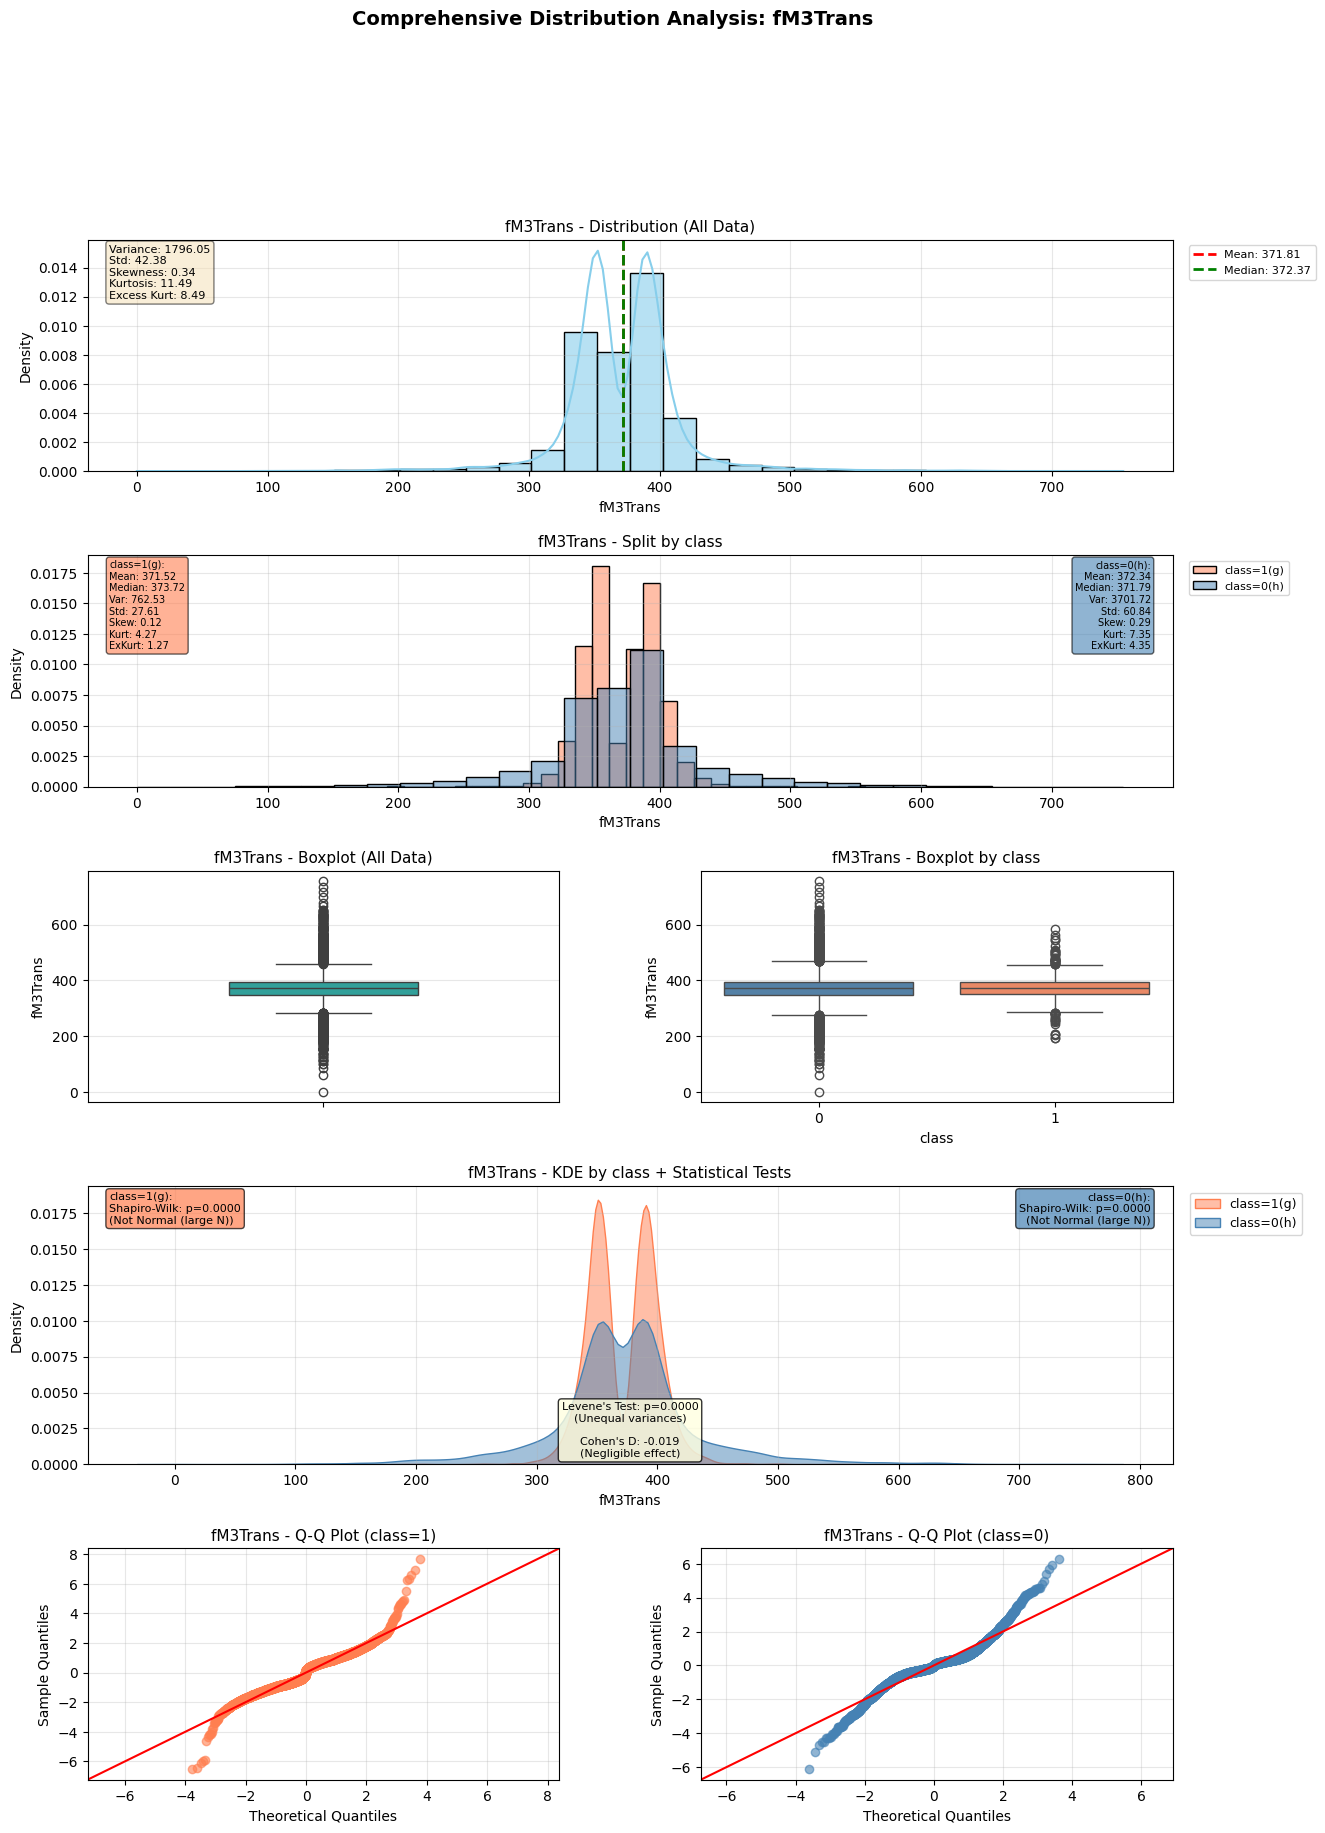

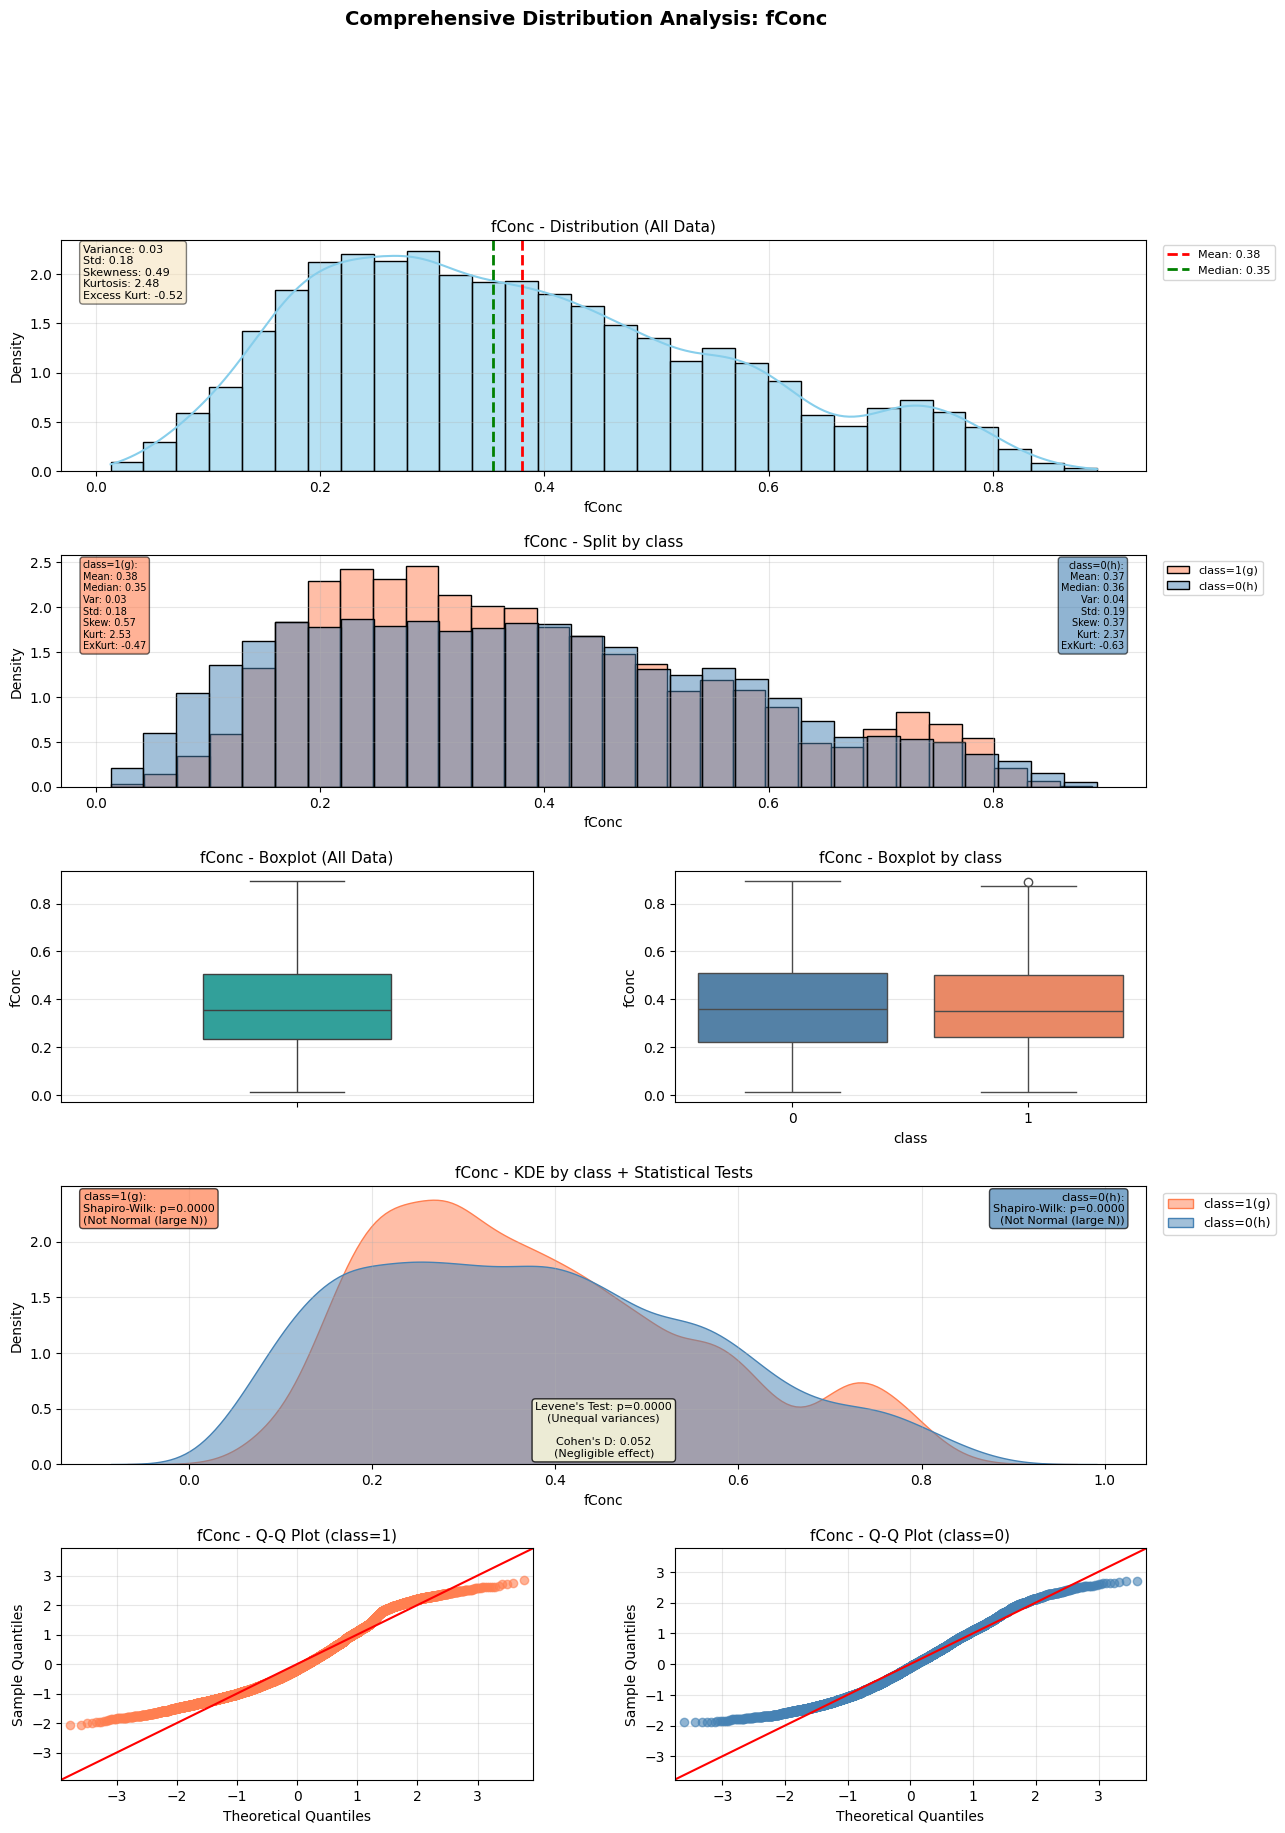

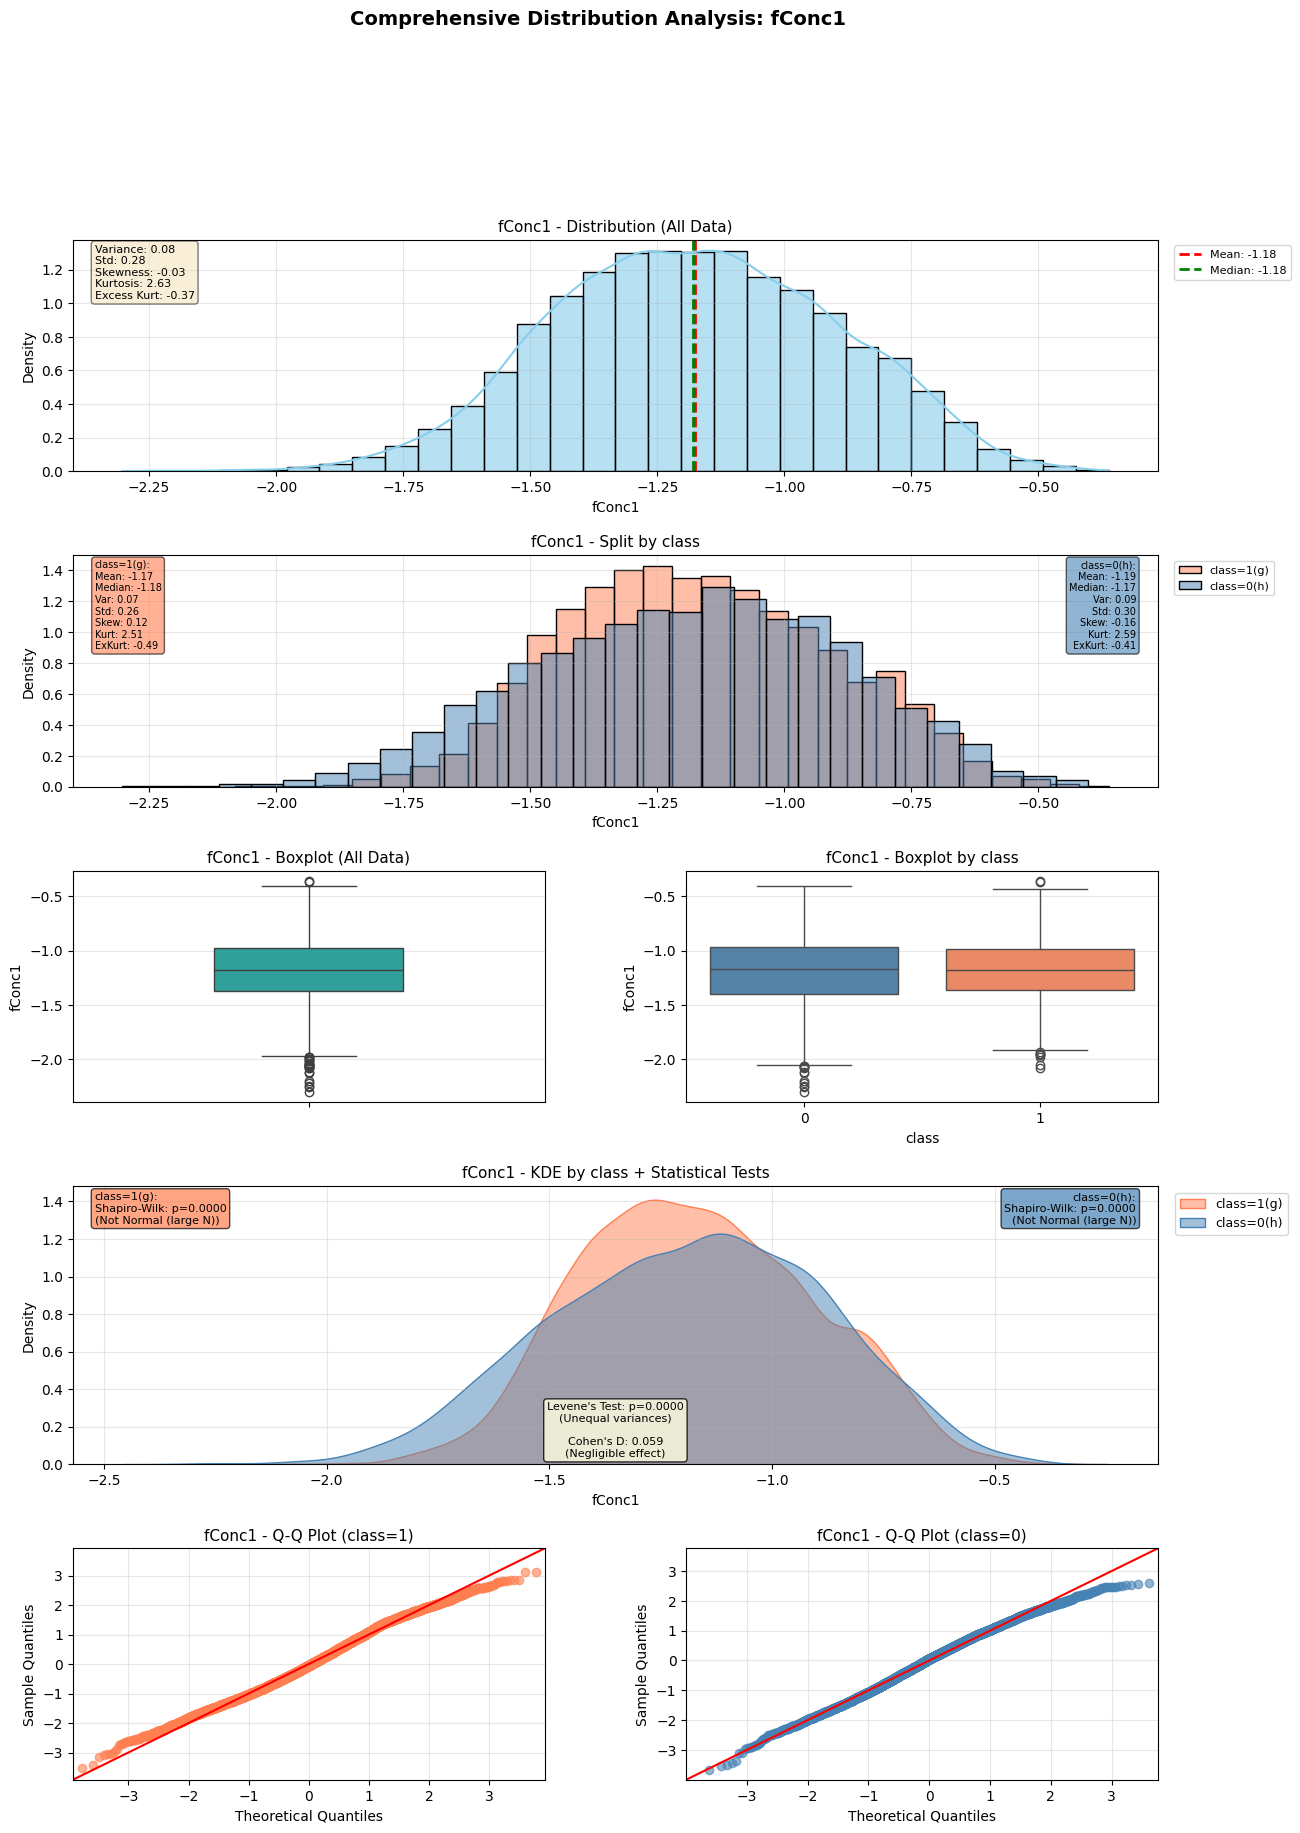

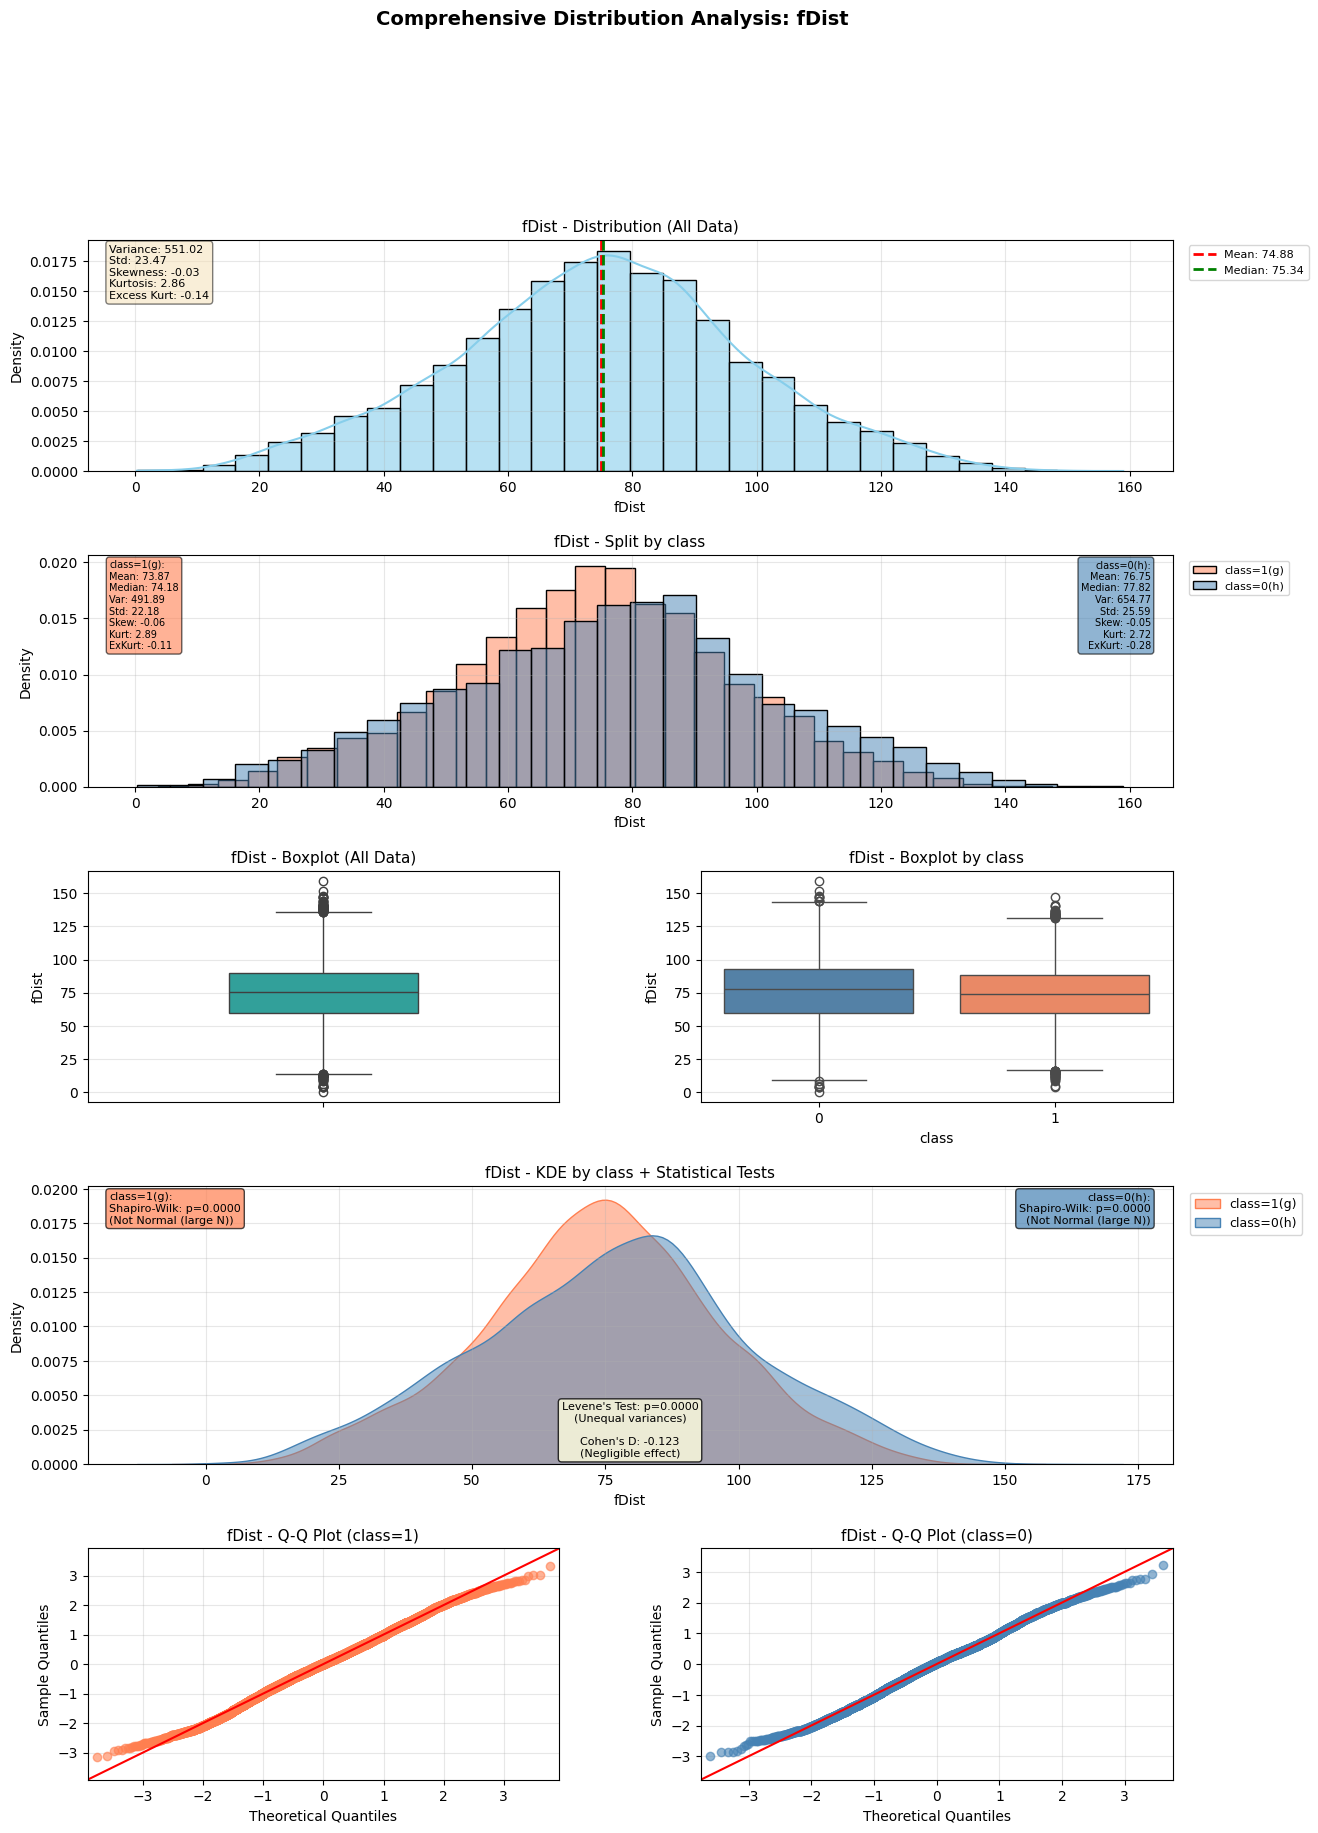

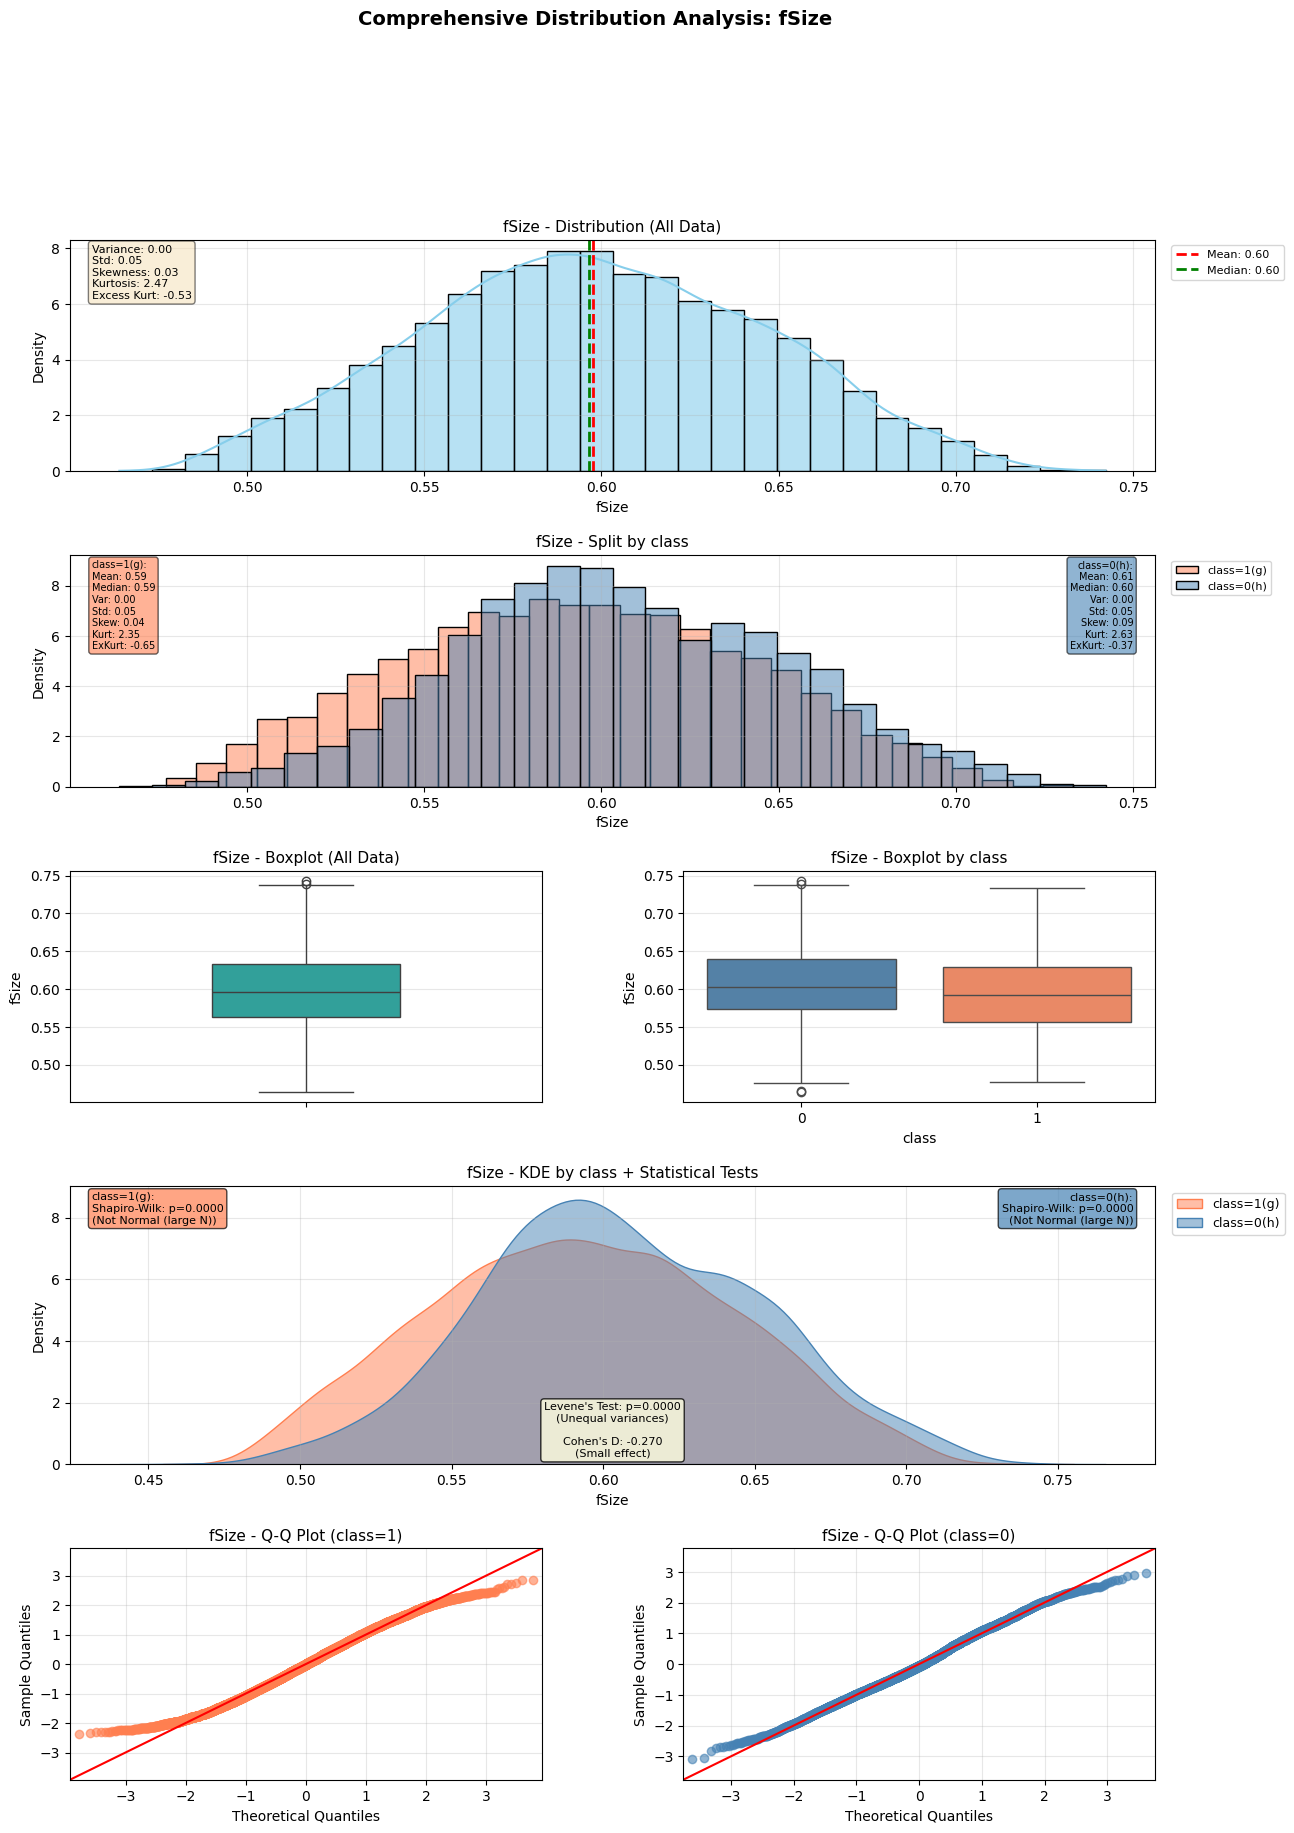

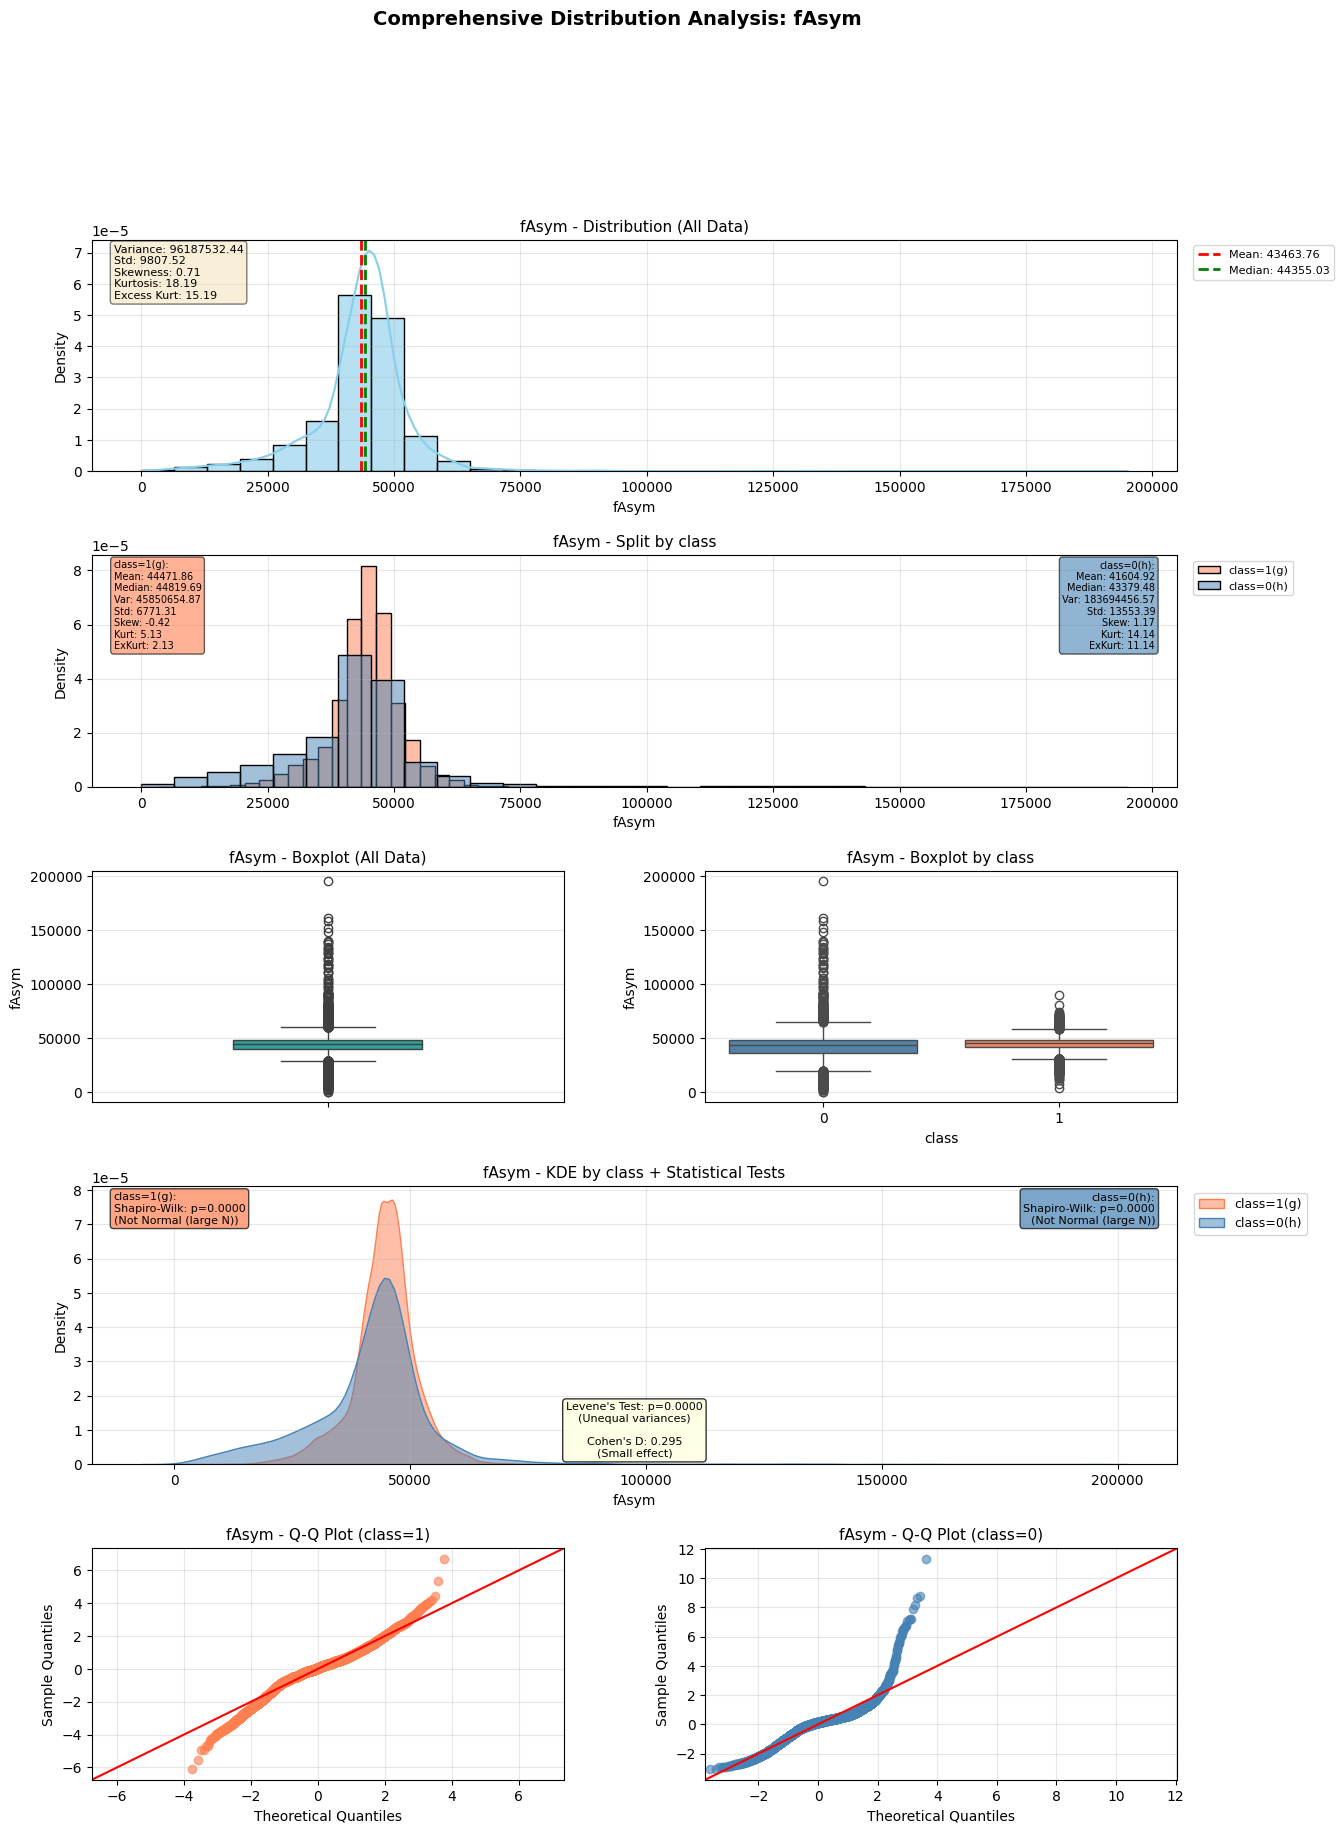

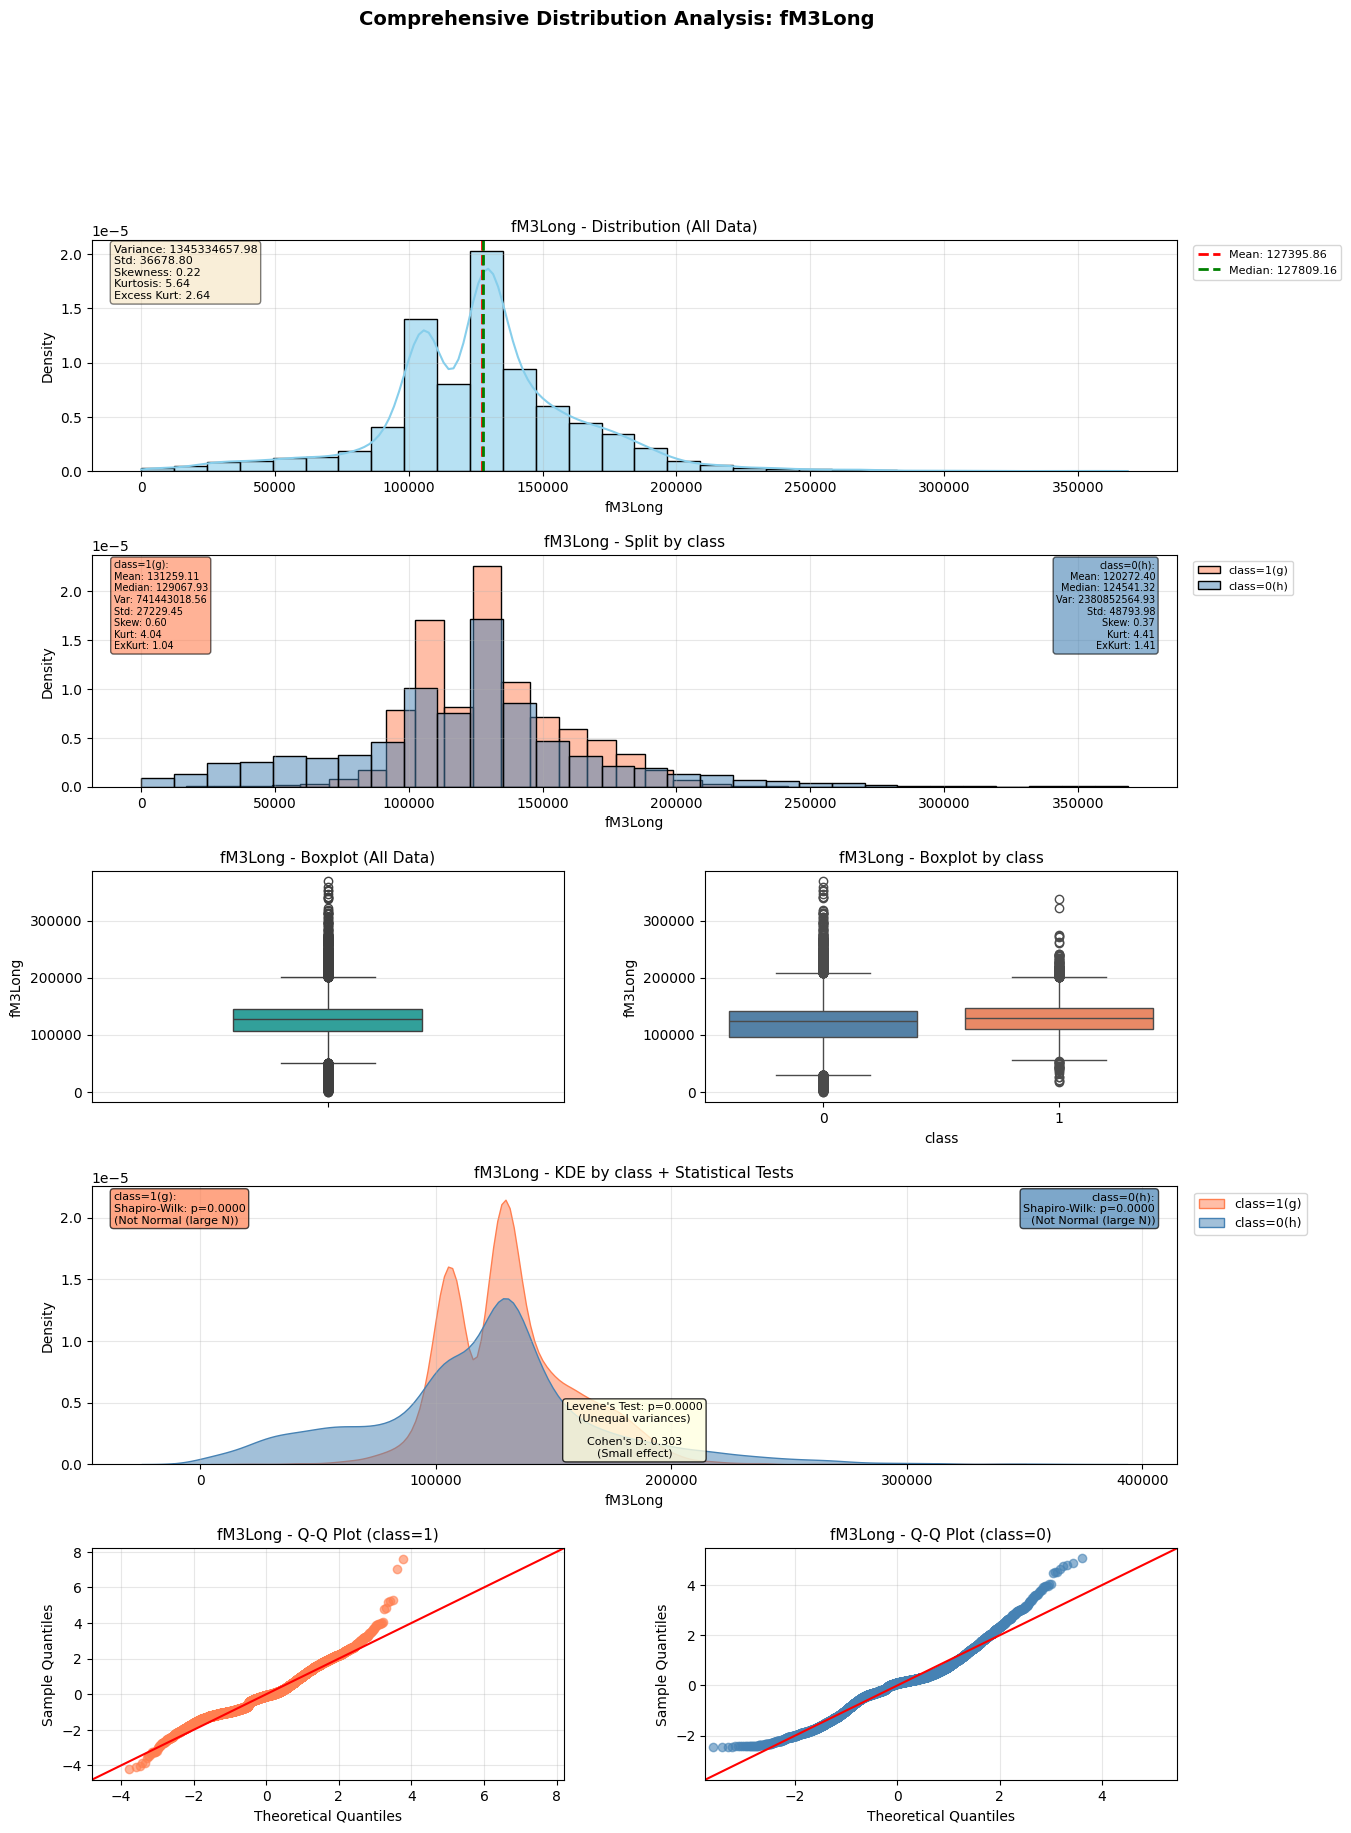

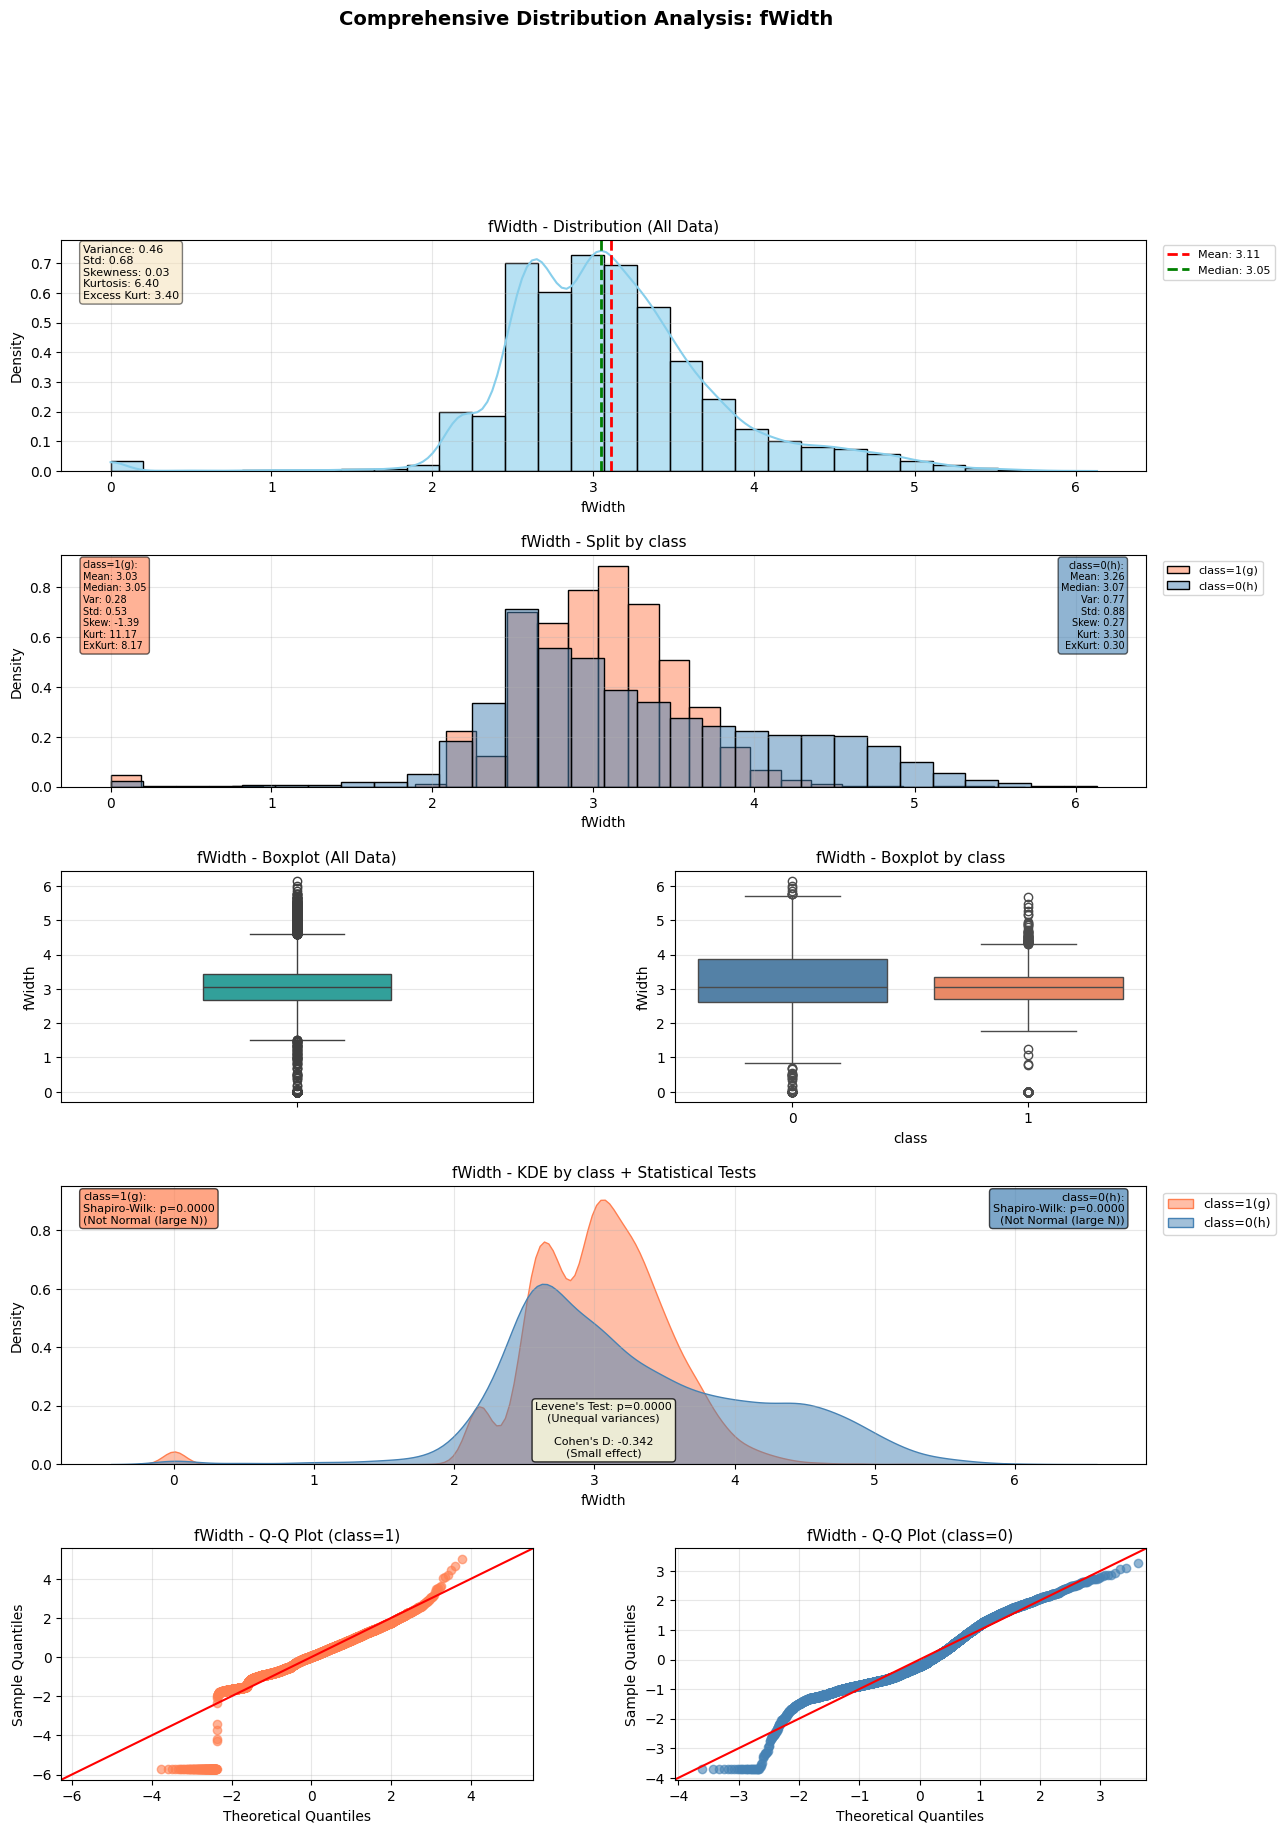

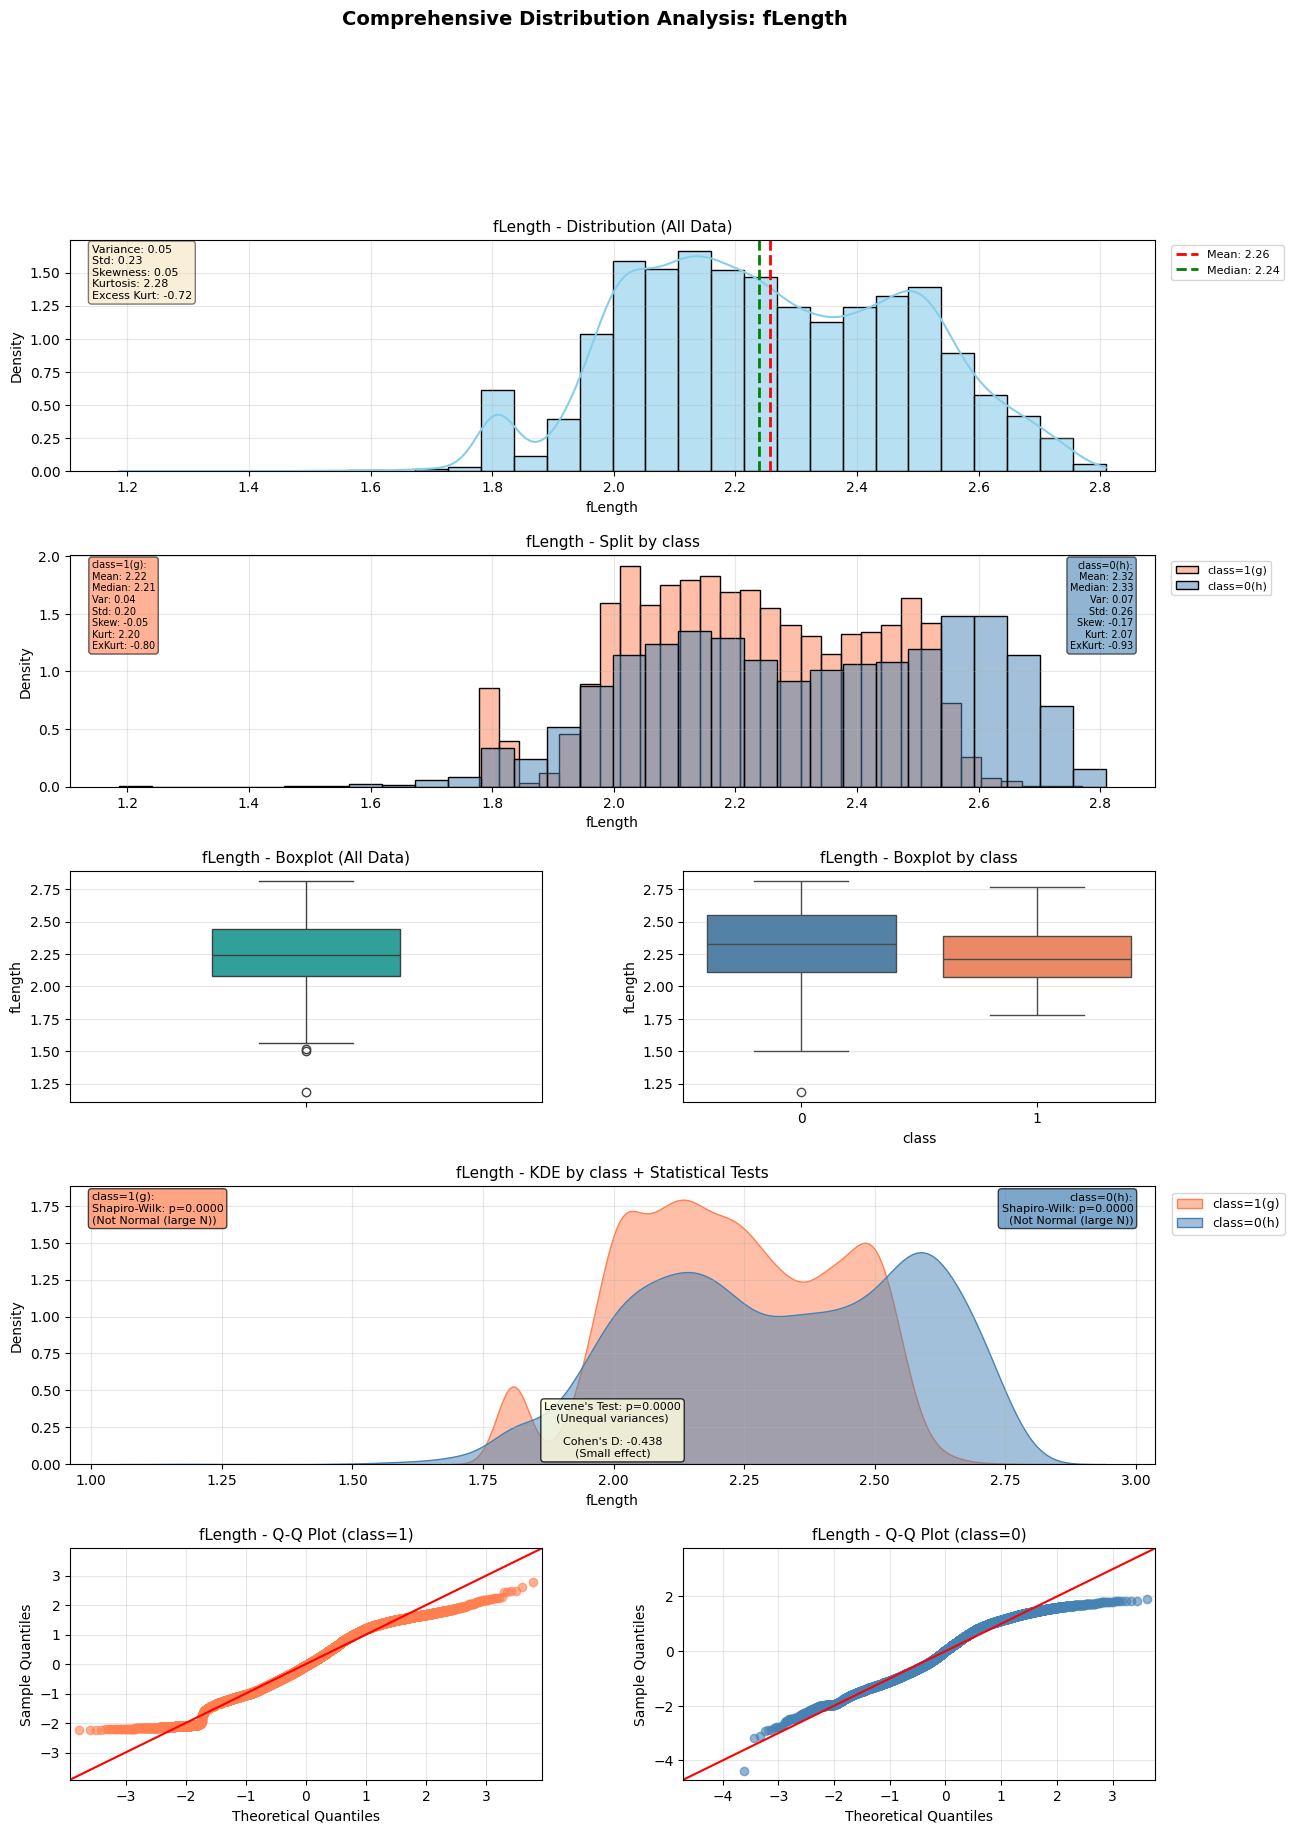

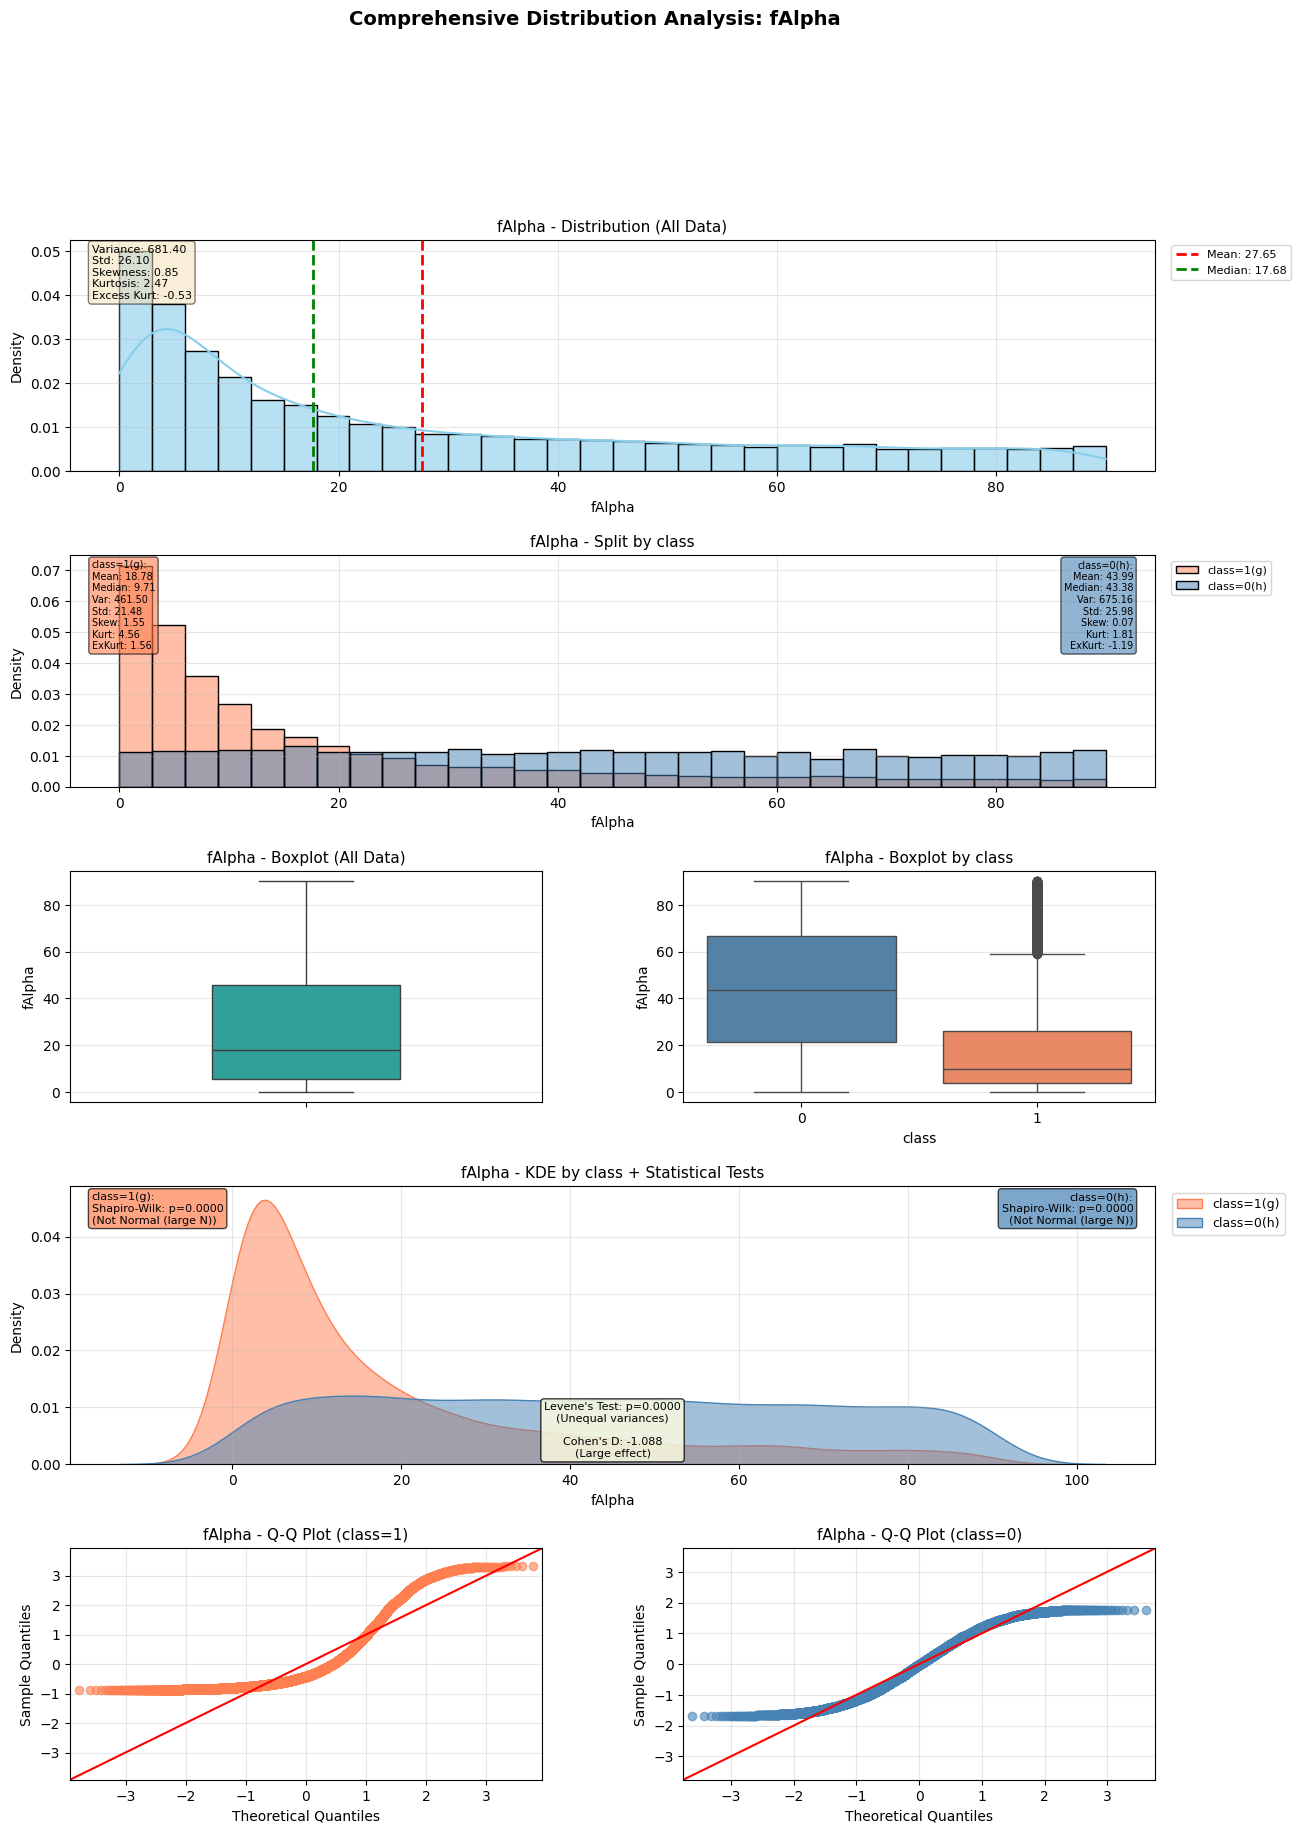

In [26]:
import statsmodels.api as sm

# Sort cols_to_visualize by absolute correlation with 'class' (descending)
correlations = numeric_df.corr()['class'].abs()
cols_to_visualize = correlations.drop('class').sort_values(ascending=True).index.tolist()

for col in cols_to_visualize:
    # Skip non-numeric columns
    if df[col].dtype not in [np.float64, np.int64, np.float32, np.int32]:
        continue
    
    # Prepare data
    data_all = df[col].dropna()
    data_g = df[df['class'] == 1][col].dropna()  # class=1 ('g')
    data_h = df[df['class'] == 0][col].dropna()  # class=0 ('h')
    
    # Skip if insufficient data
    if len(data_g) < 3 or len(data_h) < 3:
        continue
    
    # Create figure with GridSpec (5 rows)
    fig = plt.figure(figsize=(14, 20))
    gs = fig.add_gridspec(5, 2, height_ratios=[1, 1, 1, 1.2, 1], hspace=0.35, wspace=0.3)
    
    # ========== ROW 1: Histogram + KDE + Mean/Median lines (full width) ==========
    ax1 = fig.add_subplot(gs[0, :])
    sns.histplot(data_all, bins=30, kde=True, color='skyblue', ax=ax1, stat='density', alpha=0.6)
    
    # Calculate statistics
    mean_all = data_all.mean()
    median_all = data_all.median()
    variance_all = data_all.var()
    std_all = data_all.std()
    skewness_all = stats.skew(data_all)
    kurt_all = stats.kurtosis(data_all, fisher=False)  # regular kurtosis
    excess_kurt_all = stats.kurtosis(data_all, fisher=True)  # excess kurtosis
    
    # Add vertical lines for mean and median
    ax1.axvline(mean_all, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_all:.2f}')
    ax1.axvline(median_all, color='green', linestyle='--', linewidth=2, label=f'Median: {median_all:.2f}')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=True)
    ax1.set_title(f'{col} - Distribution (All Data)', fontsize=11)
    ax1.set_xlabel(col)
    ax1.set_ylabel('Density')
    ax1.grid(True, alpha=0.3)
    
    # Add text box with statistics
    textstr1 = f'Variance: {variance_all:.2f}\nStd: {std_all:.2f}\nSkewness: {skewness_all:.2f}\nKurtosis: {kurt_all:.2f}\nExcess Kurt: {excess_kurt_all:.2f}'
    ax1.text(0.02, 0.98, textstr1, transform=ax1.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # ========== ROW 2: Overlaid Histograms (class split, full width) ==========
    ax2 = fig.add_subplot(gs[1, :])
    color_0 = 'coral'
    color_1 = 'steelblue'
    
    sns.histplot(data_g, bins=30, color=color_0, alpha=0.5, label=f'class={class_mapping['g']}(g)', ax=ax2, stat='density')
    sns.histplot(data_h, bins=30, color=color_1, alpha=0.5, label=f'class={class_mapping['h']}(h)', ax=ax2, stat='density')
    
    # Calculate statistics for each group
    mean_0, median_0 = data_g.mean(), data_g.median()
    variance_0, std_0 = data_g.var(), data_g.std()
    skewness_0 = stats.skew(data_g)
    kurt_0 = stats.kurtosis(data_g, fisher=False)
    excess_kurt_0 = stats.kurtosis(data_g, fisher=True)
    
    mean_1, median_1 = data_h.mean(), data_h.median()
    variance_1, std_1 = data_h.var(), data_h.std()
    skewness_1 = stats.skew(data_h)
    kurt_1 = stats.kurtosis(data_h, fisher=False)
    excess_kurt_1 = stats.kurtosis(data_h, fisher=True)
    
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=True)
    ax2.set_title(f'{col} - Split by class', fontsize=11)
    ax2.set_xlabel(col)
    ax2.set_ylabel('Density')
    ax2.grid(True, alpha=0.3)
    
    # Text boxes for each group (color-coded)
    textstr_0 = f'class={class_mapping['g']}(g):\nMean: {mean_0:.2f}\nMedian: {median_0:.2f}\nVar: {variance_0:.2f}\nStd: {std_0:.2f}\nSkew: {skewness_0:.2f}\nKurt: {kurt_0:.2f}\nExKurt: {excess_kurt_0:.2f}'
    textstr_1 = f'class={class_mapping['h']}(h):\nMean: {mean_1:.2f}\nMedian: {median_1:.2f}\nVar: {variance_1:.2f}\nStd: {std_1:.2f}\nSkew: {skewness_1:.2f}\nKurt: {kurt_1:.2f}\nExKurt: {excess_kurt_1:.2f}'

    ax2.text(0.02, 0.98, textstr_0, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_0, alpha=0.6))
    ax2.text(0.98, 0.98, textstr_1, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=color_1, alpha=0.6))
    
    # ========== ROW 3, PLOT 1: Boxplot (all data) ==========
    ax3 = fig.add_subplot(gs[2, 0])
    sns.boxplot(y=data_all, color='lightseagreen', ax=ax3, width=0.4)
    ax3.set_title(f'{col} - Boxplot (All Data)', fontsize=11)
    ax3.set_ylabel(col)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========== ROW 3, PLOT 2: Boxplots (split by class) - FIXED ==========
    ax4 = fig.add_subplot(gs[2, 1])
    df_temp = df[[col, 'class']].dropna()
    sns.boxplot(x='class', y=col, data=df_temp, hue='class', palette=[color_1, color_0], ax=ax4, legend=False)
    ax4.set_title(f'{col} - Boxplot by class', fontsize=11)
    ax4.set_xlabel('class')
    ax4.set_ylabel(col)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ========== ROW 4: Wide KDE plot + Statistical tests ==========
    ax5 = fig.add_subplot(gs[3, :])
    sns.kdeplot(data_g, fill=True, color=color_0, label=f'class={class_mapping['g']}(g)', alpha=0.5, ax=ax5)
    sns.kdeplot(data_h, fill=True, color=color_1, label=f'class={class_mapping['h']}(h)', alpha=0.5, ax=ax5)
    ax5.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, frameon=True)
    ax5.set_title(f'{col} - KDE by class + Statistical Tests', fontsize=11)
    ax5.set_xlabel(col)
    ax5.set_ylabel('Density')
    ax5.grid(True, alpha=0.3)
    
    # Statistical tests
    # Shapiro-Wilk for each group
        # Statistical tests
    # Shapiro-Wilk for each group
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='.*For N > 5000.*') # suppress large N warning
        shapiro_0 = stats.shapiro(data_g)
        shapiro_1 = stats.shapiro(data_h)
    
    shapiro_interp_0 = 'Normal' if shapiro_0.pvalue > 0.05 else 'Not Normal'
    shapiro_interp_1 = 'Normal' if shapiro_1.pvalue > 0.05 else 'Not Normal'

    # Add note if sample size is large
    note_0 = " (large N)" if len(data_g) > 5000 else ""
    note_1 = " (large N)" if len(data_h) > 5000 else ""
    
    # Levene's test (variance equality)
    levene_test = stats.levene(data_g, data_h)
    levene_interp = 'Equal variances' if levene_test.pvalue > 0.05 else 'Unequal variances'
    
    # Cohen's D
    cohens_d = cohend(data_g, data_h)
    if abs(cohens_d) < 0.2:
        effect_interp = 'Negligible'
    elif abs(cohens_d) < 0.5:
        effect_interp = 'Small'
    elif abs(cohens_d) < 0.8:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'
    
    # Text boxes for statistical tests
    textstr_tests_0 = f"class={class_mapping['g']}(g):\nShapiro-Wilk: p={shapiro_0.pvalue:.4f}\n({shapiro_interp_0}{note_0})"
    textstr_tests_1 = f"class={class_mapping['h']}(h):\nShapiro-Wilk: p={shapiro_1.pvalue:.4f}\n({shapiro_interp_1}{note_1})"
    textstr_tests_combined = f"Levene's Test: p={levene_test.pvalue:.4f}\n({levene_interp})\n\nCohen's D: {cohens_d:.3f}\n({effect_interp} effect)"
    
    ax5.text(0.02, 0.98, textstr_tests_0, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_0, alpha=0.7))
    ax5.text(0.98, 0.98, textstr_tests_1, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=color_1, alpha=0.7))
    ax5.text(0.5, 0.02, textstr_tests_combined, transform=ax5.transAxes, fontsize=8,
             verticalalignment='bottom', horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # ========== ROW 5, PLOT 1: Q-Q plot for class=1 ==========
    ax6 = fig.add_subplot(gs[4, 0])
    sm.qqplot(data_g, line='45', ax=ax6, alpha=0.6, fit=True, markerfacecolor=color_0, markeredgecolor=color_0)
    ax6.set_title(f'{col} - Q-Q Plot (class=1)', fontsize=11)
    ax6.grid(True, alpha=0.3)
    
    # ========== ROW 5, PLOT 2: Q-Q plot for class=0 ==========
    ax7 = fig.add_subplot(gs[4, 1])
    sm.qqplot(data_h, line='45', ax=ax7, alpha=0.6, fit=True, markerfacecolor=color_1, markeredgecolor=color_1)
    ax7.set_title(f'{col} - Q-Q Plot (class=0)', fontsize=11)
    ax7.grid(True, alpha=0.3)
    
    # Final figure title
    fig.suptitle(f'Comprehensive Distribution Analysis: {col}', fontsize=14, fontweight='bold', y=0.995)
    
    plt.show()
    # print(f"Completed visualization for: {col}\n" + "="*60)

## **Hypothesis Testing**

**Test 1 - fAlpha**

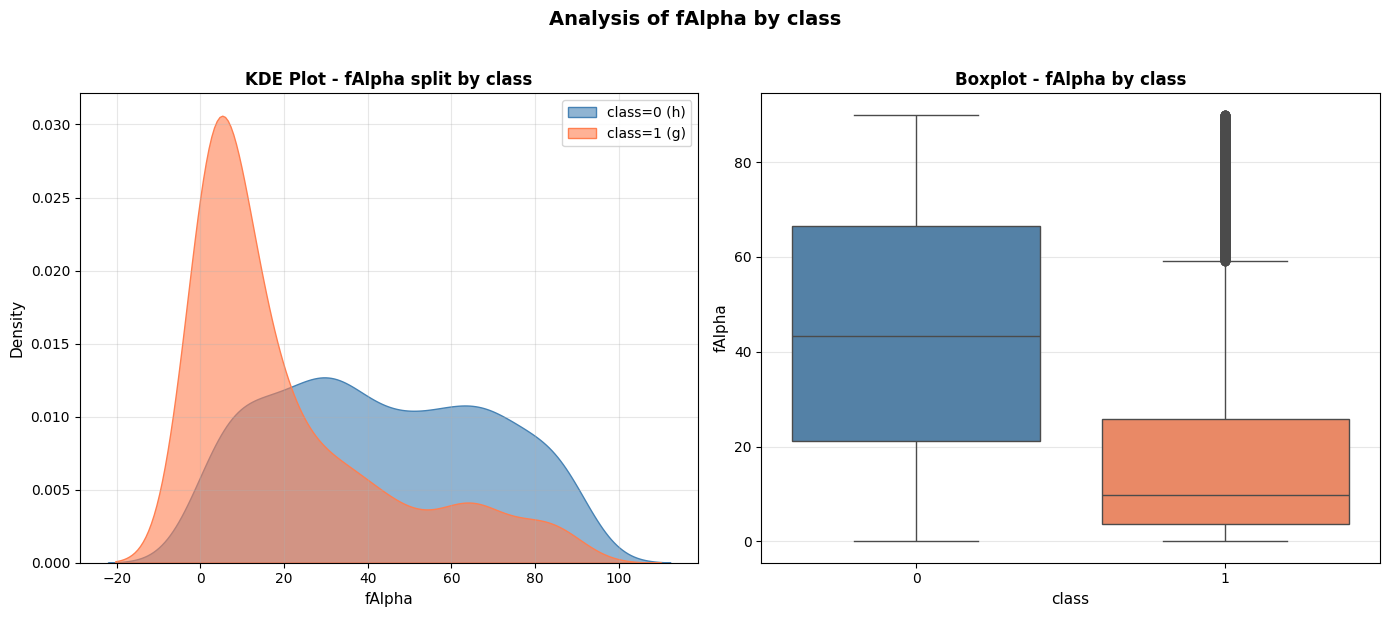

In [27]:
# Data splitting for fAlpha by class
fAlpha_class0 = df[df['class'] == 0]['fAlpha'].dropna()
fAlpha_class1 = df[df['class'] == 1]['fAlpha'].dropna()

fAlpha_class0 = fAlpha_class0.sample(n=500, random_state=42)
fAlpha_class1 = fAlpha_class1.sample(n=500, random_state=42)

# Define colors
color_0 = 'steelblue'
color_1 = 'coral'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fAlpha_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fAlpha_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fAlpha', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fAlpha split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fAlpha', 'class']].dropna()
sns.boxplot(x='class', y='fAlpha', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fAlpha', fontsize=11)
axes[1].set_title('Boxplot - fAlpha by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fAlpha by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [28]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fAlpha_class0)
shapiro_1 = stats.shapiro(fAlpha_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

Shapiro-Wilk test for class=0: W=0.9558, p-value=0.0000
Shapiro-Wilk test for class=1: W=0.7946, p-value=0.0000
class=0: Data do not appear to be normally distributed (reject H0)
class=1: Data do not appear to be normally distributed (reject H0)

At least one sample suggests non-normality. We will use Mann-Whitney U test.


In [29]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fAlpha_class0, fAlpha_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")


Levene's test for equality of variances: W=28.3264, p-value=0.0000
Variances differ (reject H0)


In [30]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fAlpha_class0 has a statistically significantly higher median than group fAlpha_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fAlpha_class0, fAlpha_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fAlpha values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fAlpha values.")


Test results:
  U-statistic: 190413.0000
  p-value: 0.0000

Conclusion:
  p-value (0.0000) < 0.05
  REJECT H0: Group with class=0 has statistically significantly
  higher fAlpha values than group with class=1.


In [31]:
# Calculate Cohen's d for fAlpha between class 0 and 1 groups

c_d = cohend(fAlpha_class1, fAlpha_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fAlpha between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fAlpha_class0), 0.05, None, 1)
print(f"Statistical power of the test for fAlpha between class=0 and class=1: {stat_power:.6f}")

Cohen's d for fAlpha between class=1 and class=0: -0.920
The effect size is large.
Statistical power of the test for fAlpha between class=0 and class=1: 1.000000


**Test 2 - fLength**

In [32]:
# Data splitting for fLength by class
fLength_class0 = df[df['class'] == 0]['fLength'].dropna()
fLength_class1 = df[df['class'] == 1]['fLength'].dropna()

fLength_class0 = fLength_class0.sample(n=500, random_state=42)
fLength_class1 = fLength_class1.sample(n=500, random_state=42)

# Define colors
color_0 = 'steelblue'
color_1 = 'coral'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fLength_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fLength_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fLength', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fLength split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fLength', 'class']].dropna()
sns.boxplot(x='class', y='fLength', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fLength', fontsize=11)
axes[1].set_title('Boxplot - fLength by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fLength by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fLength_class0)
shapiro_1 = stats.shapiro(fLength_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

In [33]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fLength_class0, fLength_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")


Levene's test for equality of variances: W=90.0483, p-value=0.0000
Variances differ (reject H0)


In [34]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fLength_class0 has a statistically significantly higher median than group fLength_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fLength_class0, fLength_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fLength values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fLength values.")


Test results:
  U-statistic: 151539.5000
  p-value: 0.0000

Conclusion:
  p-value (0.0000) < 0.05
  REJECT H0: Group with class=0 has statistically significantly
  higher fLength values than group with class=1.


In [35]:
# Calculate Cohen's d for fLength between class 0 and 1 groups

c_d = cohend(fLength_class1, fLength_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fLength between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fLength_class0), 0.05, None, 1)
print(f"Statistical power of the test for fLength between class=0 and class=1: {stat_power:.6f}")

Cohen's d for fLength between class=1 and class=0: -0.379
The effect size is medium.
Statistical power of the test for fLength between class=0 and class=1: 0.999972


**Test 3 - fDist**

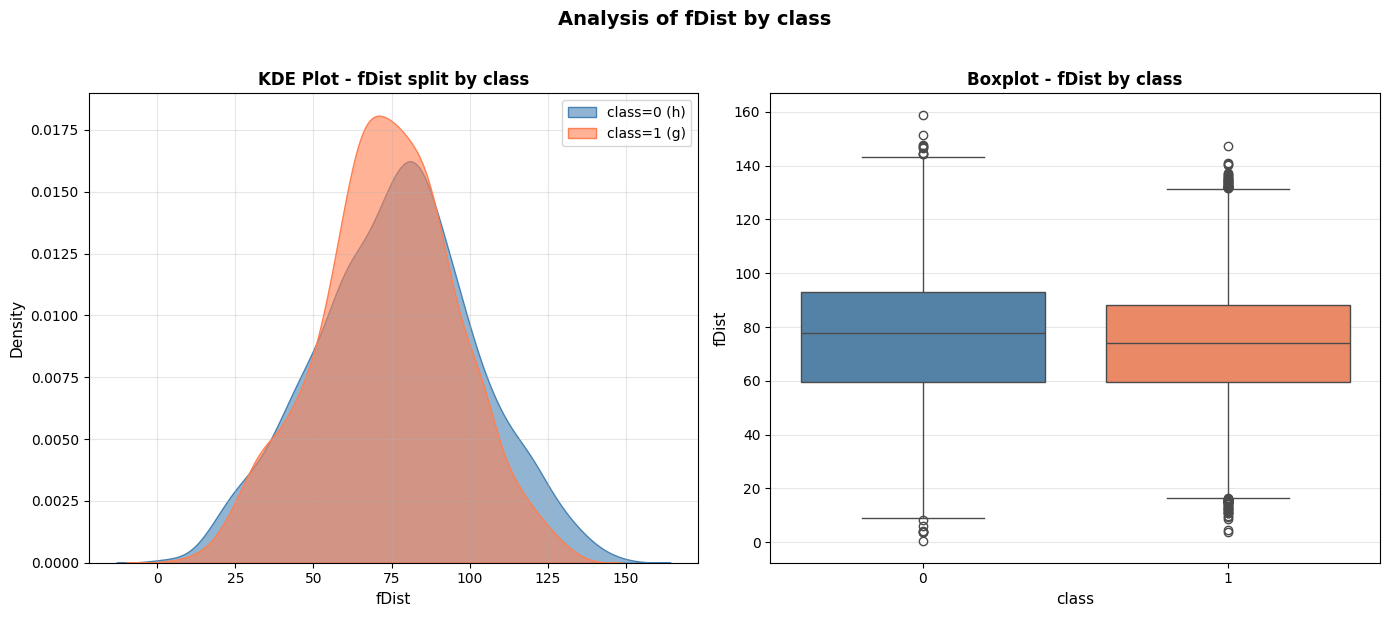

In [36]:
# Data splitting for fDist by class
fDist_class0 = df[df['class'] == 0]['fDist'].dropna()
fDist_class1 = df[df['class'] == 1]['fDist'].dropna()

fDist_class0 = fDist_class0.sample(n=2000, random_state=42)
fDist_class1 = fDist_class1.sample(n=2000, random_state=42)

# Define colors
color_0 = 'steelblue'
color_1 = 'coral'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fDist_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fDist_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fDist', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fDist split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fDist', 'class']].dropna()
sns.boxplot(x='class', y='fDist', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fDist', fontsize=11)
axes[1].set_title('Boxplot - fDist by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fDist by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [37]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fDist_class0)
shapiro_1 = stats.shapiro(fDist_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

Shapiro-Wilk test for class=0: W=0.9972, p-value=0.0010
Shapiro-Wilk test for class=1: W=0.9973, p-value=0.0015
class=0: Data do not appear to be normally distributed (reject H0)
class=1: Data do not appear to be normally distributed (reject H0)

At least one sample suggests non-normality. We will use Mann-Whitney U test.


In [38]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fDist_class0, fDist_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")


Levene's test for equality of variances: W=37.5377, p-value=0.0000
Variances differ (reject H0)


In [39]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fDist_class0 has a statistically significantly higher median than group fDist_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fDist_class0, fDist_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fDist values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fDist values.")


Test results:
  U-statistic: 2131441.0000
  p-value: 0.0002

Conclusion:
  p-value (0.0002) < 0.05
  REJECT H0: Group with class=0 has statistically significantly
  higher fDist values than group with class=1.


In [40]:
# Calculate Cohen's d for fDist between class 0 and 1 groups

c_d = cohend(fDist_class1, fDist_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fDist between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fDist_class0), 0.05, None, 1)
print(f"Statistical power of the test for fDist between class=0 and class=1: {stat_power:.6f}")

Cohen's d for fDist between class=1 and class=0: -0.117
The effect size is small.
Statistical power of the test for fDist between class=0 and class=1: 0.957972


## Part 2 - Data Preprocessing and First Experiments

In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import wandb

# Data standardization and feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [140]:
# Shuffle the dataframe randomly with a fixed random state for reproducibility
# and reset the index to start from 0
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [141]:
df.head()

fLength    fWidth     fSize     fAsym   fM3Long  fM3Trans    fAlpha  \
0 -0.795177 -0.698172 -0.907384  0.102255 -0.460410  0.337346 -0.484455   
1 -0.391723 -0.161062  0.343182  0.618043  0.068446 -0.516699 -0.847288   
2 -0.610360 -0.636691 -0.571149  0.294943 -0.109890 -0.461952  1.869276   
3  2.855160  1.885863  1.821854 -2.818236 -2.923661  1.769149 -0.771592   
4  0.474128  0.078081  0.267852 -0.564988  0.078287 -1.027024 -0.944419   

      fDist  class  
0 -0.181775      1  
1  0.352376      1  
2 -0.414279      0  
3  1.544963      0  
4  1.471514      1

In [142]:
df.shape

(19020, 9)

In [143]:
# Step 1: Remove low variance features (excluding 'class' column)
# Features with variance below threshold will be removed
variance_threshold = 0.05  # We might need to adjust this threshold

# Separate features and target
feature_cols = [col for col in df.columns if col != 'class']
X = df[feature_cols]
y = df['class']

print(f"Original number of features: {len(feature_cols)}")

# Apply variance threshold
selector = VarianceThreshold(threshold=variance_threshold)
X_selected = selector.fit_transform(X)

# Get selected feature names
selected_features = [feature_cols[i] for i in range(len(feature_cols)) if selector.get_support()[i]]
print(f"Features after variance threshold: {len(selected_features)}")
print(f"Removed features: {[f for f in feature_cols if f not in selected_features]}")

# Step 2: Apply StandardScaler to selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Create new dataframe with scaled features
df_scaled = pd.DataFrame(X_scaled, columns=selected_features, index=df.index)
df_scaled['class'] = y

print(f"\nScaled dataframe shape: {df_scaled.shape}")
print(f"Selected features: {selected_features}")

# Update df to be the scaled version
df = df_scaled.copy()

print("\nData standardization complete!")
print(f"Mean of features (should be ~0): {df[selected_features].mean().mean():.6f}")
print(f"Std of features (should be ~1): {df[selected_features].std().mean():.6f}")


Original number of features: 8
Features after variance threshold: 8
Removed features: []

Scaled dataframe shape: (19020, 9)
Selected features: ['fLength', 'fWidth', 'fSize', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Data standardization complete!
Mean of features (should be ~0): -0.000000
Std of features (should be ~1): 1.000026


In [144]:
# Split the dataframe into two based on 'class' values
data_g = df[df['class'] == class_mapping['g']]
data_h = df[df['class'] == class_mapping['h']]

# shuffle the dataframes
data_g = data_g.sample(frac=1, random_state=42).reset_index(drop=True)
data_h = data_h.sample(frac=1, random_state=42).reset_index(drop=True)

In [145]:
from sklearn.model_selection import train_test_split

# Combine all data
df_combined = pd.concat([data_g, data_h]).reset_index(drop=True)

# Split: 80% train, 20% temp
train_df, temp_df = train_test_split(
    df_combined, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_combined['class']  # Maintains class balance
)

# Split temp: 50% val, 50% test (from 20%, so 10% each of total)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['class']
)

# Verify splits
print(f"Train: {train_df.shape[0]} ({train_df.shape[0]/len(df_combined)*100:.1f}%)")
print(f"Val: {val_df.shape[0]} ({val_df.shape[0]/len(df_combined)*100:.1f}%)")
print(f"Test: {test_df.shape[0]} ({test_df.shape[0]/len(df_combined)*100:.1f}%)")

print("\nClass distribution in each split:")
print(f"Train - Class 0: {(train_df['class']==0).sum()}, Class 1: {(train_df['class']==1).sum()}")
print(f"Val - Class 0: {(val_df['class']==0).sum()}, Class 1: {(val_df['class']==1).sum()}")
print(f"Test - Class 0: {(test_df['class']==0).sum()}, Class 1: {(test_df['class']==1).sum()}")

Train: 15216 (80.0%)
Val: 1902 (10.0%)
Test: 1902 (10.0%)

Class distribution in each split:
Train - Class 0: 5350, Class 1: 9866
Val - Class 0: 669, Class 1: 1233
Test - Class 0: 669, Class 1: 1233


In [146]:
# Convert DataFrames to PyTorch tensors
def df_to_tensor(df):
    features = df.drop(columns=['class']).values
    labels = df['class'].values
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

# Create tensors for each dataset
train_features, train_labels = df_to_tensor(train_df)
val_features, val_labels = df_to_tensor(val_df)
test_features, test_labels = df_to_tensor(test_df)

print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

Train features shape: torch.Size([15216, 8]), Train labels shape: torch.Size([15216])
Validation features shape: torch.Size([1902, 8]), Validation labels shape: torch.Size([1902])
Test features shape: torch.Size([1902, 8]), Test labels shape: torch.Size([1902])


In [157]:
class NetworkConfig:
    """
    Configuration class for the Modular MLP network.
    
    Args:
        input_size (int): Number of input features
        hidden_sizes (list): List of integers defining hidden layer sizes, e.g., [128, 64, 32]
        output_size (int): Number of output neurons (1 for binary classification)
        hidden_activation (str): Activation function for hidden layers
        output_activation (str): Activation function for output layer
        dropout (float): Dropout probability (0.0 to 1.0), applied after each hidden layer
        loss_function (str): Loss function to use
        optimizer (str): Optimizer type
        learning_rate (float): Learning rate for optimizer
        weight_decay (float): L2 regularization parameter
        optimizer_params (dict): Optional optimizer-specific parameters (e.g., momentum, betas)
    """
    
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list,
        output_size: int = 1,
        hidden_activation: str = 'relu',
        output_activation: str = 'sigmoid',
        dropout: float = 0.0,
        loss_function: str = 'bce',
        optimizer: str = 'adam',
        learning_rate: float = 0.001,
        weight_decay: float = 1e-5,
        optimizer_params: dict = None
    ):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropout = dropout
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.optimizer_params = optimizer_params if optimizer_params is not None else {}
        
        # Validate configuration
        self._validate()
    
    def _validate(self):
        """Validate configuration and issue warnings for incompatible combinations."""
        
        valid_activations = ['relu', 'leaky_relu', 'tanh', 'sigmoid']
        valid_losses = ['bce', 'bce_with_logits']
        valid_optimizers = ['adam', 'adamw', 'sgd', 'rmsprop']
        
        # Check activations
        if self.hidden_activation not in valid_activations:
            raise ValueError(f"hidden_activation must be one of {valid_activations}")
        if self.output_activation not in valid_activations:
            raise ValueError(f"output_activation must be one of {valid_activations}")
        
        # Check loss function
        if self.loss_function not in valid_losses:
            raise ValueError(f"loss_function must be one of {valid_losses}")
        
        # Check optimizer
        if self.optimizer not in valid_optimizers:
            raise ValueError(f"optimizer must be one of {valid_optimizers}")
        
        # Validate dropout
        if not 0.0 <= self.dropout <= 1.0:
            raise ValueError("dropout must be between 0.0 and 1.0")
        
        # Warning: BCE requires sigmoid output
        if self.loss_function == 'bce' and self.output_activation != 'sigmoid':
            warnings.warn(
                "BCE loss typically requires sigmoid output activation. "
                f"You have output_activation='{self.output_activation}'. "
                "Consider using 'sigmoid' or switch to 'bce_with_logits'.",
                UserWarning
            )
        
        # Warning: BCE with logits should NOT have sigmoid
        if self.loss_function == 'bce_with_logits' and self.output_activation == 'sigmoid':
            warnings.warn(
                "BCEWithLogitsLoss includes sigmoid internally. "
                "Using sigmoid as output_activation will apply it twice. "
                "Consider removing output activation or using 'bce' loss instead.",
                UserWarning
            )
    
    def __repr__(self):
        return (f"NetworkConfig(\n"
                f"  Architecture: {self.input_size} -> {self.hidden_sizes} -> {self.output_size}\n"
                f"  Activations: hidden={self.hidden_activation}, output={self.output_activation}\n"
                f"  Dropout: {self.dropout}\n"
                f"  Loss: {self.loss_function}\n"
                f"  Optimizer: {self.optimizer} (lr={self.learning_rate}, wd={self.weight_decay})\n"
                f"  Optimizer params: {self.optimizer_params}\n"
                f")")

print("NetworkConfig class loaded successfully!")

NetworkConfig class loaded successfully!


In [158]:
class ModularMLP(nn.Module):
    """
    Modular Multi-Layer Perceptron with configurable architecture using nn.Sequential.
    
    Features:
    - Dynamic layer construction from config
    - Multiple activation functions
    - Optional dropout after each hidden layer
    - Proper weight initialization
    """
    
    def __init__(self, config: NetworkConfig):
        super(ModularMLP, self).__init__()
        
        self.config = config
        
        # Build network architecture
        self.network = self._build_network()
        
        # Initialize weights
        self._initialize_weights()
        
        print(f"\n{'='*60}")
        print(f"Modular MLP Network Created")
        print(f"{'='*60}")
        print(self.config)
        print(f"Total parameters: {self.count_parameters():,}")
        print(f"\nNetwork Architecture:")
        print(self.network)
        print(f"{'='*60}\n")
    
    def _build_network(self):
        """Dynamically build network layers using nn.Sequential."""

        
        # Build all layer sizes: input -> hidden layers -> output
        layer_sizes = [self.config.input_size] + self.config.hidden_sizes + [self.config.output_size]
        
        # Store layers in a list first
        modules = []
        
        # Build hidden layers with activation and dropout
        for i in range(len(layer_sizes) - 2):  # All hidden layers
            # Linear layer
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            
            # Activation
            modules.append(self._get_activation(self.config.hidden_activation))
            
            # Dropout (if specified)
            if self.config.dropout > 0:
                modules.append(nn.Dropout(self.config.dropout))
        
        # Output layer
        modules.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        
        # Output activation
        modules.append(self._get_activation(self.config.output_activation))
        
        # Return as Sequential
        return nn.Sequential(*modules)
    
    def _get_activation(self, name: str):
        """Return activation function by name."""
        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }
        return activations[name]
    
    def _initialize_weights(self):
        """Initialize network weights using appropriate methods."""
        for module in self.network:
            if isinstance(module, nn.Linear):
                # Use Kaiming initialization for relu/leaky_relu, Xavier for others
                if self.config.hidden_activation in ['relu', 'leaky_relu']:
                    nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                else:
                    nn.init.xavier_normal_(module.weight)
                
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        """Forward pass through the network."""
        return self.network(x)
    
    def count_parameters(self):
        """Count total trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_device(self):
        """Get the device the model is on."""
        return next(self.parameters()).device

print("ModularMLP class loaded successfully!")

ModularMLP class loaded successfully!


In [161]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from pathlib import Path
from datetime import datetime

class MLPTrainer:
    """
    Training utility for ModularMLP with validation and early stopping.
    """
    
    def __init__(self, model: ModularMLP, config: NetworkConfig, device=None, 
                 save_model=False, save_dir='saved_models', model_name=None,
                 best_metric='f1'):
        """
        Initialize trainer.
        
        Args:
            model: ModularMLP instance
            config: NetworkConfig instance
            device: torch device (defaults to cuda if available)
            save_model: If True, saves best model to disk during training
            save_dir: Directory to save models (default: 'saved_models')
            model_name: Custom model name (default: auto-generated with timestamp)
            best_metric: Metric to use for model selection (default: 'f1')
                       Options: 'loss', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'mcc'
        """
        self.model = model
        self.config = config
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        # Save settings
        self.save_model = save_model
        self.save_dir = Path(save_dir)
        
        # Best metric configuration
        valid_metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'mcc']
        if best_metric not in valid_metrics:
            raise ValueError(f"best_metric must be one of {valid_metrics}")
        
        self.best_metric = best_metric
        self.best_metric_value = float('inf') if best_metric == 'loss' else 0.0
        self.maximize_metric = best_metric != 'loss'  # All metrics except loss should be maximized
        
        # Generate model name if not provided
        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            arch_str = "_".join(map(str, config.hidden_sizes))
            self.model_name = f"mlp_{arch_str}_{config.optimizer}_{timestamp}.pth"
        else:
            self.model_name = model_name if model_name.endswith('.pth') else f"{model_name}.pth"
        
        self.model_path = self.save_dir / self.model_name
        
        # Create save directory if saving is enabled
        if self.save_model:
            self.save_dir.mkdir(parents=True, exist_ok=True)
            print(f"Model will be saved to: {self.model_path}")
        
        # Setup loss function
        self.criterion = self._get_loss_function()
        
        # Setup optimizer
        self.optimizer = self._get_optimizer()
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'train_precision': [],
            'val_precision': [],
            'train_recall': [],
            'val_recall': [],
            'train_f1': [],
            'val_f1': [],
            'train_auc': [],
            'val_auc': [],
            'train_mcc': [],
            'val_mcc': []
        }
        
        print(f"Trainer initialized on device: {self.device}")
        print(f"Best model selection metric: {self.best_metric} ({'minimize' if not self.maximize_metric else 'maximize'})")
    
    def _get_loss_function(self):
        """Get loss function based on config."""
        if self.config.loss_function == 'bce':
            return nn.BCELoss()
        elif self.config.loss_function == 'bce_with_logits':
            return nn.BCEWithLogitsLoss()
        # elif self.config.loss_function == 'CEL':
        #     return nn.CrossEntropyLoss()
    
    def _get_optimizer(self):
        """Get optimizer based on config with custom parameters."""
        optimizers_map = {
            'adam': optim.Adam,
            'adamw': optim.AdamW,
            'sgd': optim.SGD,
            'rmsprop': optim.RMSprop
        }
        
        optimizer_class = optimizers_map[self.config.optimizer]
        
        # Base parameters
        params = {
            'lr': self.config.learning_rate,
            'weight_decay': self.config.weight_decay
        }
        
        # Add optimizer-specific parameters with defaults
        if self.config.optimizer == 'sgd':
            params['momentum'] = self.config.optimizer_params.get('momentum', 0.9)
        elif self.config.optimizer in ['adam', 'adamw']:
            params['betas'] = self.config.optimizer_params.get('betas', (0.9, 0.999))
            params['eps'] = self.config.optimizer_params.get('eps', 1e-8)
        elif self.config.optimizer == 'rmsprop':
            params['alpha'] = self.config.optimizer_params.get('alpha', 0.99)
            params['eps'] = self.config.optimizer_params.get('eps', 1e-8)
            params['momentum'] = self.config.optimizer_params.get('momentum', 0)
        
        # Merge any additional custom parameters
        for key, value in self.config.optimizer_params.items():
            if key not in params:
                params[key] = value
        
        return optimizer_class(self.model.parameters(), **params)
    
    def _calculate_metrics(self, labels, preds, probs):
        """Calculate all classification metrics."""
        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, zero_division=0)
        recall = recall_score(labels, preds, zero_division=0)
        f1 = f1_score(labels, preds, zero_division=0)
        
        # AUC requires probabilities
        try:
            auc = roc_auc_score(labels, probs)
        except:
            auc = 0.0
        
        # Matthews Correlation Coefficient
        mcc = matthews_corrcoef(labels, preds)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'mcc': mcc
        }
    
    def _is_better_metric(self, current_value, best_value):
        """Check if current metric value is better than the best value."""
        if self.maximize_metric:
            return current_value > best_value
        else:
            return current_value < best_value
    
    def save_checkpoint(self, epoch, val_metrics, is_best=False):
        """
        Save model checkpoint to disk.
        
        Args:
            epoch: Current epoch number
            val_metrics: Dictionary of validation metrics
            is_best: Whether this is the best model so far
        """
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config.__dict__,
            'history': self.history,
            'val_metrics': val_metrics,
            'best_metric': self.best_metric,
            'best_metric_value': val_metrics.get(self.best_metric, val_metrics.get('loss')),
            'is_best': is_best
        }
        
        torch.save(checkpoint, self.model_path)
        print(f"  ✓ Model saved to {self.model_path}")
    
    @staticmethod
    def load_checkpoint(path, device=None):
        """
        Load a saved model checkpoint.
        
        Args:
            path: Path to the checkpoint file
            device: Device to load model to (defaults to cuda if available)
        
        Returns:
            trainer: Loaded MLPTrainer instance
            epoch: Epoch number when saved
            val_metrics: Validation metrics when saved
        """
        device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        checkpoint = torch.load(path, map_location=device)
        
        # Reconstruct config
        config = NetworkConfig(**checkpoint['config'])
        
        # Reconstruct model
        model = ModularMLP(config)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Get best_metric from checkpoint if available, otherwise default to 'f1'
        best_metric = checkpoint.get('best_metric', 'f1')
        
        # Reconstruct trainer
        trainer = MLPTrainer(model, config, device, save_model=False, best_metric=best_metric)
        trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Restore history if available
        if 'history' in checkpoint:
            trainer.history = checkpoint['history']
        
        epoch = checkpoint.get('epoch', 0)
        val_metrics = checkpoint.get('val_metrics', {})
        best_metric_value = checkpoint.get('best_metric_value', 0.0)
        
        print(f"✓ Model loaded from {path}")
        print(f"  Epoch: {epoch}")
        print(f"  Best metric ({best_metric}): {best_metric_value:.4f}")
        
        return trainer, epoch, val_metrics
    
    def train(self, train_loader, val_loader, epochs=100, patience=10, verbose=True):
        """
        Train the model with early stopping.
        
        Args:
            train_loader: DataLoader for training data (automatically shuffles each epoch)
            val_loader: DataLoader for validation data
            epochs: Maximum number of epochs
            patience: Early stopping patience
            verbose: Print progress
        """
        
        best_val_metric = self.best_metric_value
        patience_counter = 0
        best_model_state = None
        best_epoch = 0

        wandb.login(key="0968c06d619bf5ef6fabebaba71df0b0b6c7806b")
        wandb.init(project="new_model", name="baseline_run")
        
        print(f"\n{'='*60}")
        print(f"Training Configuration:")
        print(f"  Epochs: {epochs}")
        print(f"  Batch size: {train_loader.batch_size}")
        print(f"  Steps per epoch: {len(train_loader)}")
        print(f"  Training samples: {len(train_loader.dataset)}")
        print(f"  Validation samples: {len(val_loader.dataset)}")
        print(f"  Data shuffling: Enabled (shuffle=True in DataLoader)")
        print(f"  Best metric: {self.best_metric} ({'maximize' if self.maximize_metric else 'minimize'})")
        print(f"  Save to disk: {'Yes - ' + str(self.model_path) if self.save_model else 'No'}")
        print(f"{'='*60}\n")
        
        for epoch in range(epochs):
            # Training phase (data is automatically shuffled by DataLoader)
            train_metrics = self._train_epoch(train_loader)
            
            # Validation phase
            val_metrics = self._validate_epoch(val_loader)

                    
            # Save history
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['train_acc'].append(train_metrics['accuracy'])
            self.history['val_acc'].append(val_metrics['accuracy'])
            self.history['train_precision'].append(train_metrics['precision'])
            self.history['val_precision'].append(val_metrics['precision'])
            self.history['train_recall'].append(train_metrics['recall'])
            self.history['val_recall'].append(val_metrics['recall'])
            self.history['train_f1'].append(train_metrics['f1'])
            self.history['val_f1'].append(val_metrics['f1'])
            self.history['train_auc'].append(train_metrics['auc'])
            self.history['val_auc'].append(val_metrics['auc'])
            self.history['train_mcc'].append(train_metrics['mcc'])
            self.history['val_mcc'].append(val_metrics['mcc'])

            wandb.log({
                "epoch": epoch,
                
                # --- Train ---
                "train/loss": train_metrics['loss'],
                "train/accuracy": train_metrics['accuracy'],
                "train/f1": train_metrics['f1'],
            
                # --- Validation ---
                "val/loss": val_metrics['loss'],
                "val/accuracy": val_metrics['accuracy'],
                "val/f1": val_metrics['f1'],
                "val/auc": val_metrics['auc'],
            })

            
            # Print progress with extended metrics
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}]")
                print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.4f}, "
                      f"Prec: {train_metrics['precision']:.4f}, Rec: {train_metrics['recall']:.4f}, "
                      f"F1: {train_metrics['f1']:.4f}, AUC: {train_metrics['auc']:.4f}, MCC: {train_metrics['mcc']:.4f}")
                print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}, "
                      f"Prec: {val_metrics['precision']:.4f}, Rec: {val_metrics['recall']:.4f}, "
                      f"F1: {val_metrics['f1']:.4f}, AUC: {val_metrics['auc']:.4f}, MCC: {val_metrics['mcc']:.4f}")
            
            # Early stopping check based on selected metric
            current_metric_value = val_metrics[self.best_metric]
            
            if self._is_better_metric(current_metric_value, best_val_metric):
                best_val_metric = current_metric_value
                patience_counter = 0
                best_model_state = self.model.state_dict().copy()
                best_epoch = epoch + 1
                
                # Save to disk if enabled
                if self.save_model:
                    self.save_checkpoint(epoch + 1, val_metrics, is_best=True)
                
                if verbose:
                    print(f"  ✓ New best {self.best_metric}: {current_metric_value:.4f}")
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break
        
        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            if verbose:
                print(f"\nRestored best model from epoch {best_epoch} with {self.best_metric}: {best_val_metric:.4f}")
        wandb.finish()
    
    def _train_epoch(self, train_loader):
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        for features, labels in train_loader:
            features = features.to(self.device)
            labels = labels.to(self.device).float().unsqueeze(1)  # Shape: (batch, 1)
            
            # Forward pass
            outputs = self.model(features)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.detach().cpu().numpy())
        
        avg_loss = total_loss / len(train_loader)
        metrics = self._calculate_metrics(all_labels, all_preds, all_probs)
        metrics['loss'] = avg_loss
        
        return metrics
    
    def _validate_epoch(self, val_loader):
        """Validate for one epoch."""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(self.device)
                labels = labels.to(self.device).float().unsqueeze(1)
                
                outputs = self.model(features)
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
        
        avg_loss = total_loss / len(val_loader)
        metrics = self._calculate_metrics(all_labels, all_preds, all_probs)
        metrics['loss'] = avg_loss
        
        return metrics
    
    def evaluate(self, test_loader):
        """Evaluate model on test set."""
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for features, labels in test_loader:
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(features)
                preds = (outputs >= 0.5).float().squeeze()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
        
        # Calculate all metrics
        metrics = self._calculate_metrics(all_labels, all_preds, all_probs)
        conf_matrix = confusion_matrix(all_labels, all_preds)
        class_report = classification_report(all_labels, all_preds, target_names=['Class 0 (h)', 'Class 1 (g)'])
        
        print(f"\n{'='*60}")
        print(f"Test Set Evaluation")
        print(f"{'='*60}")
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1-Score:  {metrics['f1']:.4f}")
        print(f"ROC-AUC:   {metrics['auc']:.4f}")
        print(f"MCC:       {metrics['mcc']:.4f}")
        print(f"\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nClassification Report:")
        print(class_report)
        print(f"{'='*60}\n")
        
        return metrics, conf_matrix, all_preds, all_probs
    
    def plot_history(self):
        """Plot training history with all metrics."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        metrics = [
            ('Loss', 'train_loss', 'val_loss'),
            ('Accuracy', 'train_acc', 'val_acc'),
            ('Precision', 'train_precision', 'val_precision'),
            ('Recall', 'train_recall', 'val_recall'),
            ('F1-Score', 'train_f1', 'val_f1'),
            ('ROC-AUC', 'train_auc', 'val_auc')
        ]
        
        for idx, (title, train_key, val_key) in enumerate(metrics):
            row = idx // 3
            col = idx % 3
            ax = axes[row, col]
            
            ax.plot(self.history[train_key], label=f'Train {title}', color='blue', alpha=0.7)
            ax.plot(self.history[val_key], label=f'Val {title}', color='orange', alpha=0.7)
            ax.set_xlabel('Epoch')
            ax.set_ylabel(title)
            ax.set_title(f'Training and Validation {title}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot for MCC
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(self.history['train_mcc'], label='Train MCC', color='blue', alpha=0.7)
        ax.plot(self.history['val_mcc'], label='Val MCC', color='orange', alpha=0.7)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Matthews Correlation Coefficient')
        ax.set_title('Training and Validation MCC')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

print("MLPTrainer class loaded successfully!")

MLPTrainer class loaded successfully!



Modular MLP Network Created
NetworkConfig(
  Architecture: 8 -> [128, 64, 32] -> 1
  Activations: hidden=relu, output=sigmoid
  Dropout: 0.3
  Loss: bce
  Optimizer: adam (lr=0.001, wd=1e-05)
  Optimizer params: {}
)
Total parameters: 11,521

Network Architecture:
Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)

Trainer initialized on device: cpu
Best model selection metric: f1 (maximize)

Training Simple Adam Network...

Training Configuration:
  Epochs: 100
  Batch size: 64
  Steps per epoch: 238
  Training samples: 15216
  Validation samples: 1902
  Data shuffling: Enabled (shuffle=True in DataLoader)
  Best metric: f1 

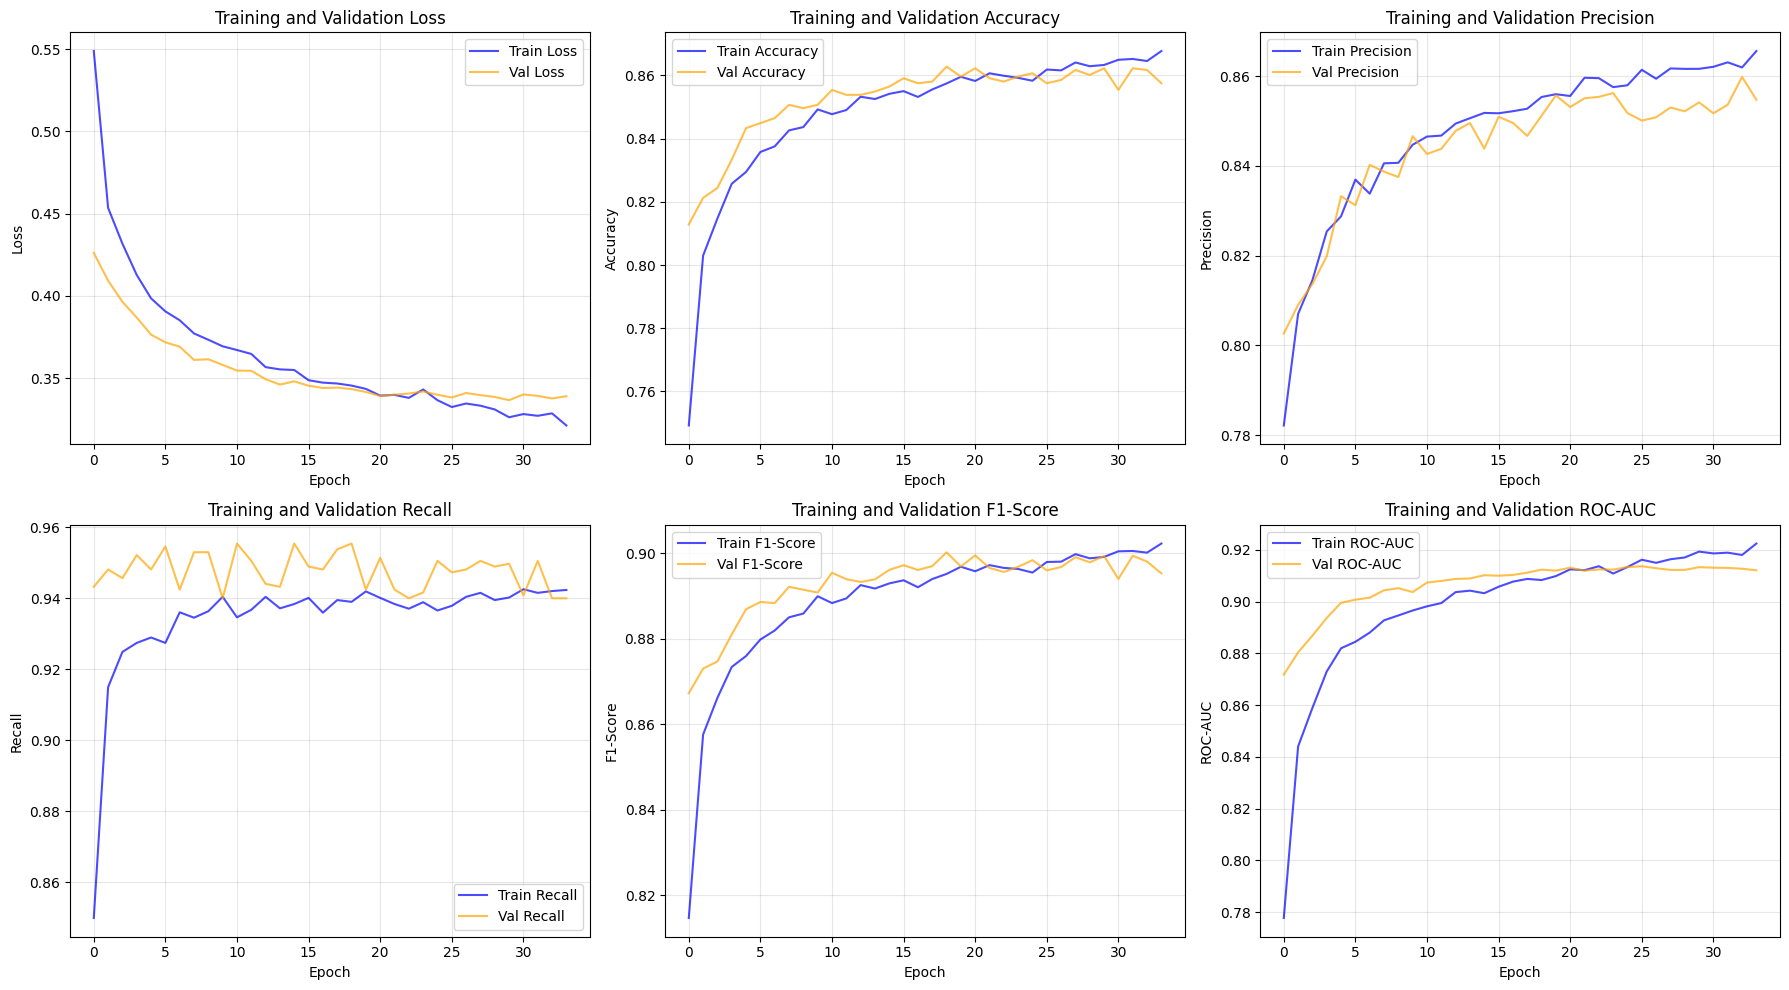

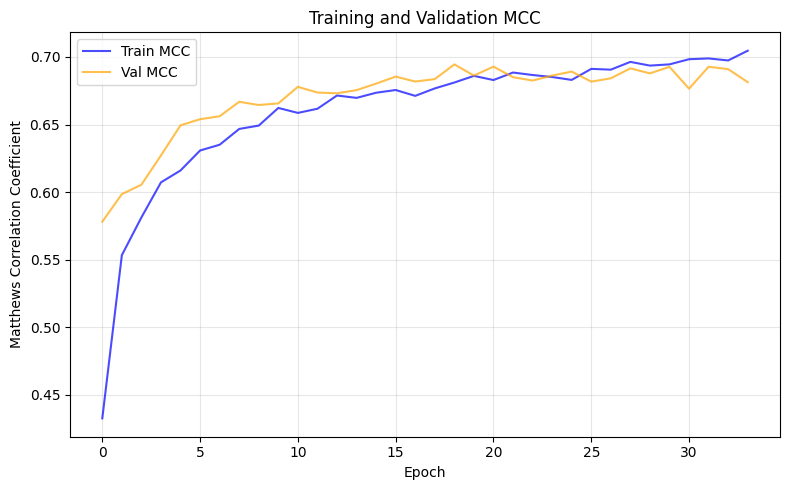


Test Set Evaluation
Accuracy:  0.8796
Precision: 0.8780
Recall:    0.9457
F1-Score:  0.9106
ROC-AUC:   0.9328
MCC:       0.7318

Confusion Matrix:
[[ 507  162]
 [  67 1166]]

Classification Report:
              precision    recall  f1-score   support

 Class 0 (h)       0.88      0.76      0.82       669
 Class 1 (g)       0.88      0.95      0.91      1233

    accuracy                           0.88      1902
   macro avg       0.88      0.85      0.86      1902
weighted avg       0.88      0.88      0.88      1902




In [150]:
# Example 1: Simple network with Adam optimizer and default parameters

config1 = NetworkConfig(
    input_size=train_features.shape[1],
    hidden_sizes=[128, 64, 32],
    output_size=1,
    hidden_activation='relu',
    output_activation='sigmoid',
    dropout=0.3,
    loss_function='bce',
    optimizer='adam',
    learning_rate=0.001,
    weight_decay=1e-5
)

model1 = ModularMLP(config1)
trainer1 = MLPTrainer(model1, config1)

# Create data loaders
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("\nTraining Simple Adam Network...")
trainer1.train(train_loader, val_loader, epochs=100, patience=15, verbose=True)

trainer1.plot_history()
accuracy1, conf_matrix1, preds1, probs1 = trainer1.evaluate(test_loader)

In [ ]:
# Example 2: Network with SGD optimizer and custom momentum

config2 = NetworkConfig(
    input_size=train_features.shape[1],
    hidden_sizes=[256, 128, 64],
    output_size=1,
    hidden_activation='leaky_relu',
    output_activation='sigmoid',
    dropout=0.4,
    loss_function='bce',
    optimizer='sgd',
    learning_rate=0.01,
    weight_decay=1e-4,
    optimizer_params={
        'momentum': 0.95,
    }
)

model2 = ModularMLP(config2)
trainer2 = MLPTrainer(model2, config2)

print("\nTraining SGD Network with Custom Momentum...")
trainer2.train(train_loader, val_loader, epochs=100, patience=15, verbose=True)

trainer2.plot_history()
accuracy2, conf_matrix2, preds2, probs2 = trainer2.evaluate(test_loader)

In [ ]:
# Example 2: Network with SGD optimizer and custom momentum

config3 = NetworkConfig(
    input_size=train_features.shape[1],
    hidden_sizes=[18, 10],
    output_size=1,
    hidden_activation='relu',
    output_activation='sigmoid',
    dropout=0,
    loss_function='bce',
    optimizer='adam',
    learning_rate=0.01,
    weight_decay=1e-4,
)

model3 = ModularMLP(config3)
trainer3 = MLPTrainer(model3, config3)

print("\nTraining Adam Network...")
trainer3.train(train_loader, val_loader, epochs=100, patience=20, verbose=True)

trainer3.plot_history()
accuracy3, conf_matrix3, preds3, probs3 = trainer3.evaluate(test_loader)


Modular MLP Network Created
NetworkConfig(
  Architecture: 8 -> [128, 64, 32, 16] -> 1
  Activations: hidden=leaky_relu, output=sigmoid
  Dropout: 0
  Loss: bce
  Optimizer: adam (lr=0.023, wd=0.0001)
  Optimizer params: {}
)
Total parameters: 12,033

Network Architecture:
Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=16, out_features=1, bias=True)
  (9): Sigmoid()
)

Trainer initialized on device: cpu
Best model selection metric: f1 (maximize)

Training Adam Network...


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nikio\_netrc



Training Configuration:
  Epochs: 100
  Batch size: 64
  Steps per epoch: 238
  Training samples: 15216
  Validation samples: 1902
  Data shuffling: Enabled (shuffle=True in DataLoader)
  Best metric: f1 (maximize)
  Save to disk: No

  ✓ New best f1: 0.8926
  ✓ New best f1: 0.8938
  ✓ New best f1: 0.8945
Epoch [10/100]
  Train - Loss: 0.3248, Acc: 0.8651, Prec: 0.8630, Rec: 0.9413, F1: 0.9005, AUC: 0.9197, MCC: 0.6986
  Val   - Loss: 0.3478, Acc: 0.8586, Prec: 0.8613, Rec: 0.9319, F1: 0.8952, AUC: 0.9124, MCC: 0.6838
  ✓ New best f1: 0.8952
  ✓ New best f1: 0.8957
  ✓ New best f1: 0.8971
  ✓ New best f1: 0.8990
Epoch [20/100]
  Train - Loss: 0.3198, Acc: 0.8680, Prec: 0.8650, Rec: 0.9437, F1: 0.9027, AUC: 0.9221, MCC: 0.7054
  Val   - Loss: 0.3343, Acc: 0.8575, Prec: 0.8465, Rec: 0.9530, F1: 0.8966, AUC: 0.9151, MCC: 0.6823
  ✓ New best f1: 0.8996
  ✓ New best f1: 0.9008
Epoch [30/100]
  Train - Loss: 0.3158, Acc: 0.8686, Prec: 0.8668, Rec: 0.9422, F1: 0.9029, AUC: 0.9245, MCC: 0.706

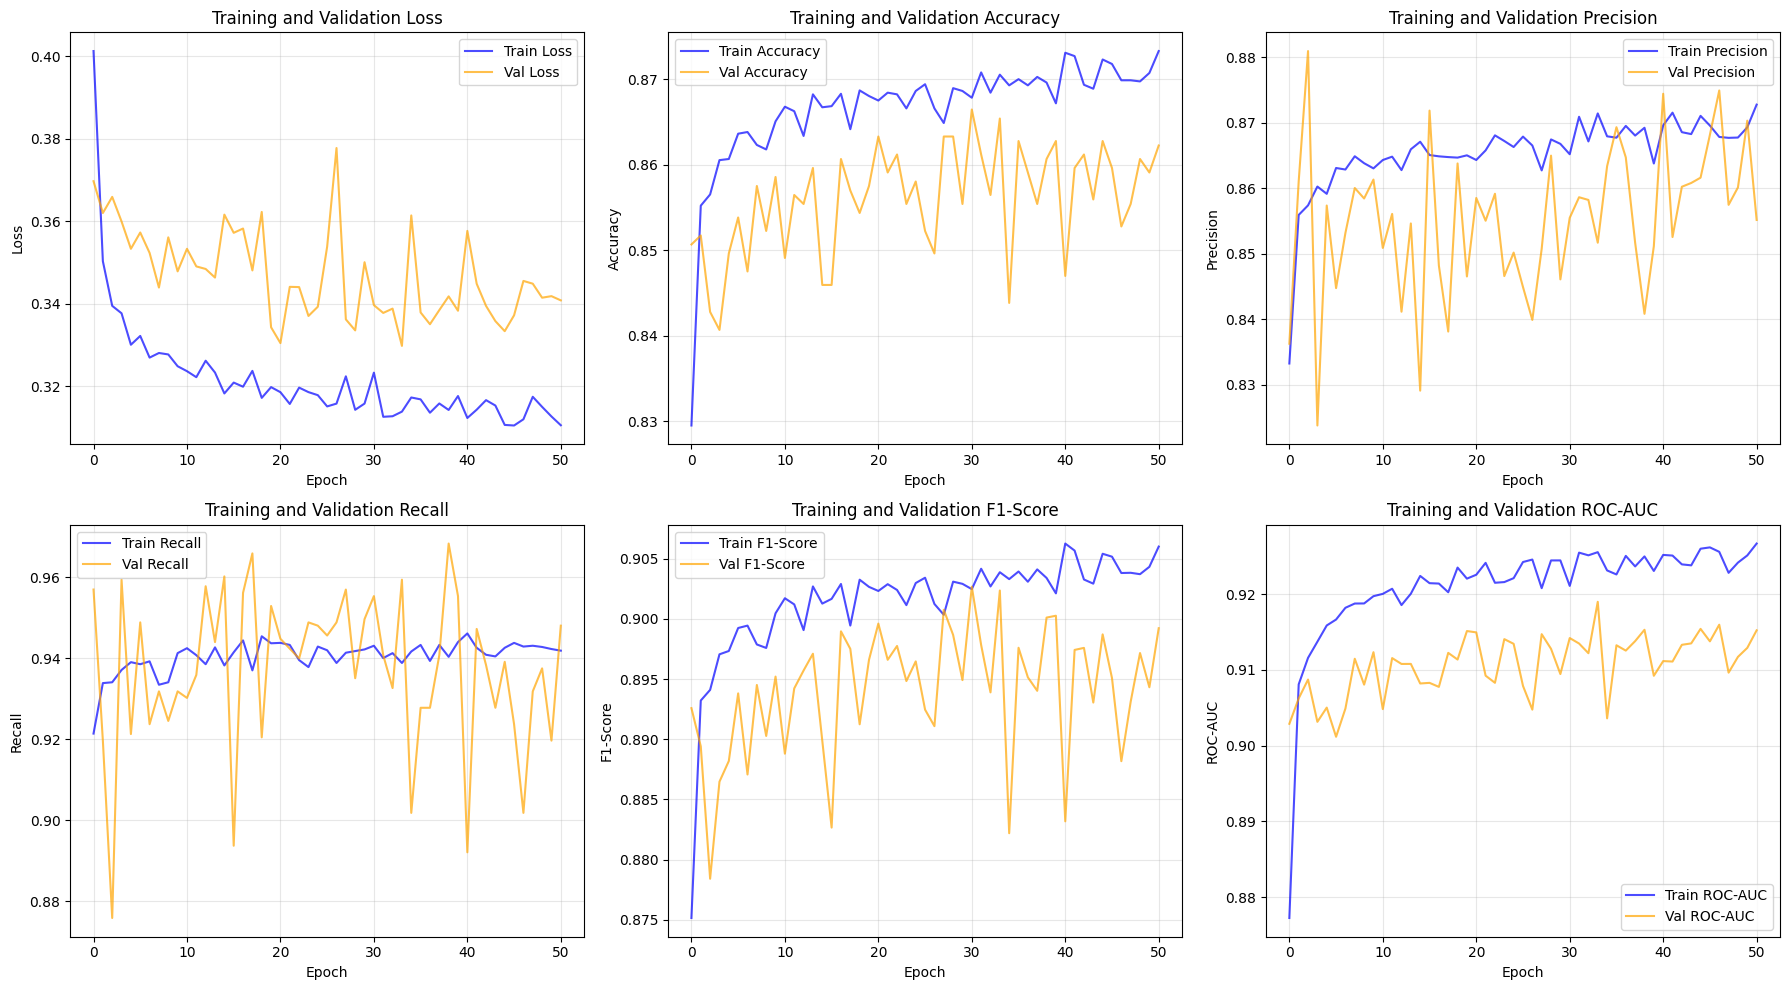

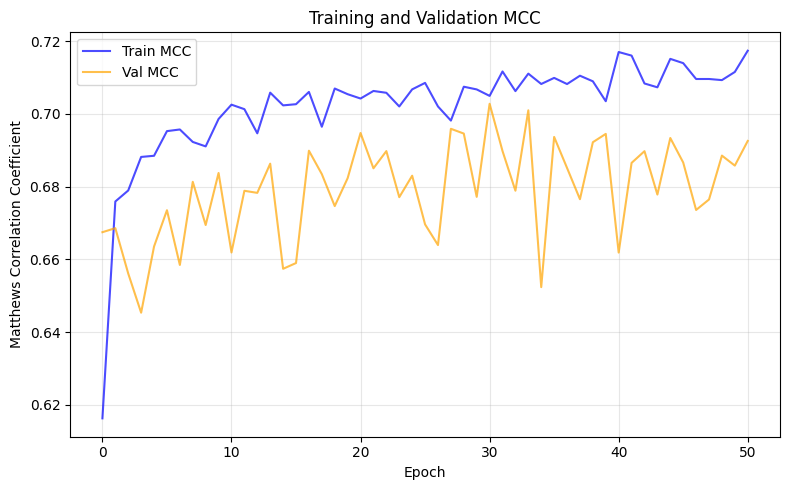


Test Set Evaluation
Accuracy:  0.8738
Precision: 0.8681
Recall:    0.9497
F1-Score:  0.9070
ROC-AUC:   0.9324
MCC:       0.7189

Confusion Matrix:
[[ 491  178]
 [  62 1171]]

Classification Report:
              precision    recall  f1-score   support

 Class 0 (h)       0.89      0.73      0.80       669
 Class 1 (g)       0.87      0.95      0.91      1233

    accuracy                           0.87      1902
   macro avg       0.88      0.84      0.86      1902
weighted avg       0.88      0.87      0.87      1902




In [162]:
# Example 2: Network with SGD optimizer and custom momentum

config3 = NetworkConfig(
    input_size=train_features.shape[1],
    hidden_sizes=[128, 64, 32, 16],
    output_size=1,
    hidden_activation='leaky_relu',
    output_activation='sigmoid',
    dropout=0,
    loss_function='bce',
    optimizer='adam',
    learning_rate=0.023,
    weight_decay=1e-4,
)

model3 = ModularMLP(config3)
trainer3 = MLPTrainer(model3, config3)

print("\nTraining Adam Network...")
trainer3.train(train_loader, val_loader, epochs=100, patience=20, verbose=True)

trainer3.plot_history()
accuracy3, conf_matrix3, preds3, probs3 = trainer3.evaluate(test_loader)